<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2011 to 2022 (12 years).</div></small>

### Mounting Google Drive (if is not running locally)

In [1]:
def is_running_in_colab():
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        %cd '/content/gdrive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'
        %ls
        return True
    except ImportError:
        return False

if is_running_in_colab():
    print("Running inside Google Colab!")
else:
    print("Not running inside Google Colab.")

Not running inside Google Colab.


### Installing libs

In [2]:
%pip install arch
%pip install beautifulsoup4
%pip install chardet
%pip install files
%pip install matplotlib
%pip install pmdarima
%pip install requests
%pip install seaborn
%pip install statsmodels
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

### Setting Display

In [3]:
import pandas as pd

pd.set_option('display.max_columns', 15)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 400)
#pd.reset_option('display.width')

## 1 Downloading and loading stock market data from the CVM website.

### 1.1 Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| Taesa         | TAEE11    | 20257     |

### 1.2 Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

### 1.3 File Types

In [4]:
file_types = ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
print(f'file_types selected: {file_types}')

file_types selected: ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']


### 1.4 Interval of years

In [5]:
year_interval_begin = 2011
year_interval_end = 2023
years = range(year_interval_begin, year_interval_end+1)

### 1.5 Download directory

In [6]:
download_dir = "downloaded_files"

### 1.6 Downloading balance sheets files

In [7]:
import os
import chardet
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile


def is_utf8(file_path):
    """Check if the file encoding is UTF-8."""
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

def download_zips(base_url, download_dir, years_to_download):
    """Download ZIP files for the specified years."""
    response = requests.get(base_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    for link in links:
        file_url = urljoin(base_url, link["href"])
        if file_url.endswith(".zip"):
            zip_file_name = os.path.basename(file_url)
            year_part = zip_file_name.split("_")[-1].split(".")[0]
            if year_part in years_to_download:
                if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                    print(f"Downloading: {zip_file_name}")
                    with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                        file_response = requests.get(file_url)
                        file.write(file_response.content)
                else:
                    print(f"File already exists: {zip_file_name}")

def unzip_files(download_dir):
    """Unzip downloaded ZIP files."""
    for zip_file_name in os.listdir(download_dir):
        if zip_file_name.endswith(".zip"):
            zip_file_path = os.path.join(download_dir, zip_file_name)
            zip_subdir = os.path.splitext(zip_file_name)[0]
            zip_subdir_path = os.path.join(download_dir, zip_subdir)

            if not os.path.exists(zip_subdir_path):
                print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(zip_subdir_path)

def process_files(download_dir, file_types):
    """Process unzipped files."""
    for zip_subdir in os.listdir(download_dir):
        zip_subdir_path = os.path.join(download_dir, zip_subdir)
        marker_file_path = os.path.join(zip_subdir_path, "processed.txt")

        if os.path.isdir(zip_subdir_path) and not os.path.exists(marker_file_path):
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"File type: {csv_file_type}")
                    if (csv_file_type not in file_types) or \
                        ("ind" in file_name) or \
                        ("DFC_MD" in file_name) or \
                        ("itr_cia_aberta_20" in file_name):

                        os.remove(file_path)
                        print(f"Removing file: {file_path}")
                    elif file_name.endswith(".csv") and not is_utf8(file_path):
                        print(f"Converting encoding: {file_path}")
                        with open(file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)

            # Create the marker file after processing all files in the directory
            with open(marker_file_path, 'w') as marker_file:
                marker_file.write("Files in this directory have been processed.")

base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"
os.makedirs(download_dir, exist_ok=True)
years_to_download = set(str(year) for year in years)

download_zips(base_url, download_dir, years_to_download)
unzip_files(download_dir)
process_files(download_dir, file_types)

print("Download, extraction, file removal, and encoding conversion completed.")


File already exists: itr_cia_aberta_2011.zip
File already exists: itr_cia_aberta_2012.zip
File already exists: itr_cia_aberta_2013.zip
File already exists: itr_cia_aberta_2014.zip
File already exists: itr_cia_aberta_2015.zip
File already exists: itr_cia_aberta_2016.zip
File already exists: itr_cia_aberta_2017.zip
File already exists: itr_cia_aberta_2018.zip
File already exists: itr_cia_aberta_2019.zip
File already exists: itr_cia_aberta_2020.zip
File already exists: itr_cia_aberta_2021.zip
File already exists: itr_cia_aberta_2022.zip
File already exists: itr_cia_aberta_2023.zip
Download, extraction, file removal, and encoding conversion completed.


### 1.7 Creating the dataframes

In [8]:
import os
import pandas as pd

dataframes = {
    'BPA': None,
    'BPP': None,
    'DRE': None,
    'DRA': None,
    'DMPL': None,
    'DFC': None,
    'DVA': None
}

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            if csv_file_name.endswith(".csv"):
                csv_file_path = os.path.join(dir_path, csv_file_name)
                print("\n-------------------------------------------------------")
                print(f"Reading csv file: {csv_file_path}")

                csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
                print(f"CSV type: {csv_file_type}")

                local_df = pd.read_csv(csv_file_path, sep=';')

                local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
                local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

                print(f"Dataframe size: {len(local_df)}")

                # Checking if the file type is in dataframes dictionary
                if csv_file_type in dataframes:
                    if dataframes[csv_file_type] is None:
                        dataframes[csv_file_type] = local_df
                    else:
                        dataframes[csv_file_type] = pd.concat([dataframes[csv_file_type], local_df])
                    print(f"Dataframe size - after concat: {len(dataframes[csv_file_type])}")

for key, df in dataframes.items():
    print(f"\n{key}:")
    print(df.head(2))



-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPA_con_2011.csv
CSV type: BPA
Dataframe size: 135870
Dataframe size - after concat: 135870

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPP_con_2011.csv
CSV type: BPP
Dataframe size: 231544
Dataframe size - after concat: 231544

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DFC_MI_con_2011.csv
CSV type: DFC
Dataframe size: 81094
Dataframe size - after concat: 81094

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DMPL_con_2011.csv
CSV type: DMPL
Dataframe size: 470968
Dataframe size - after concat: 470968

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_a

### 1.8 Saving Dataframes

#### 1.8.1 Creating column DT_INI_EXERC

In [9]:
import pandas as pd


def createDT_INI_EXERC(df_name, df):
    """Creating column DT_INI_EXERC"""
    print(f'Creating column DT_INI_EXERC for: {df_name} accounts')

    target_values = [
        'DF Consolidado - Balanço Patrimonial Ativo',
        'DF Consolidado - Balanço Patrimonial Passivo'
    ]
    df['DT_FIM_EXERC'] = pd.to_datetime(df['DT_FIM_EXERC'])

    df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)

    cols = list(df.columns)
    cols.remove('DT_INI_EXERC')
    cols.insert(9, 'DT_INI_EXERC')
    df = df[cols]
    
    print("\n")
    print(df.head())

    return df


# Creating column DT_INI_EXERC for BPA and BPP accounts
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = createDT_INI_EXERC(key, df)
        dataframes[key] = df




Creating column DT_INI_EXERC for: BPA accounts


/tmp/ipykernel_718440/35185332.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)




             CNPJ_CIA   DT_REFER  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_INI_EXERC DT_FIM_EXERC CD_CONTA                       DS_CONTA     VL_CONTA ST_CONTA_FIXA
0  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31        1                    Ativo Total  146901002.0             S
1  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2010-12-31   2011-03-31        1                    Ativo Total  149751700.0             S
2  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31     1.01               Ativo Circulante   328

/tmp/ipykernel_718440/35185332.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)




             CNPJ_CIA   DT_REFER  VERSAO                             DENOM_CIA  CD_CVM                                     GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_INI_EXERC DT_FIM_EXERC CD_CONTA                           DS_CONTA     VL_CONTA ST_CONTA_FIXA
0  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31        2                      Passivo Total  146901002.0             S
1  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL      ÚLTIMO   2010-12-31   2011-03-31        2                      Passivo Total  149751700.0             S
2  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31     2.01                 

#### 1.8.2 Saving

In [10]:
import os

processed_folder = 'processed_files'

os.makedirs(processed_folder, exist_ok=True)

print("\n")
def saveToFile(dfName, df, directory='.'):
    fileName = "df_" + dfName + '.csv'
    df = df.set_index('DT_REFER')
    print("\n-----------------------------------------------------------------")
    print(f'saving file: {fileName}\n')
    print('\ndf.info():\n')
    print(df.info())
    print("\ndf:\n")
    print(df)
    df.to_csv(directory + '/' + fileName, sep=';')

for key, df in dataframes.items():
    if df is not None:
        saveToFile(key, df, processed_folder)




-----------------------------------------------------------------
saving file: df_BPA.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1783648 entries, 2011-03-31 to 2023-06-30
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   CNPJ_CIA       object        
 1   VERSAO         int64         
 2   DENOM_CIA      object        
 3   CD_CVM         int64         
 4   GRUPO_DFP      object        
 5   MOEDA          object        
 6   ESCALA_MOEDA   object        
 7   ORDEM_EXERC    object        
 8   DT_INI_EXERC   datetime64[ns]
 9   DT_FIM_EXERC   datetime64[ns]
 10  CD_CONTA       object        
 11  DS_CONTA       object        
 12  VL_CONTA       float64       
 13  ST_CONTA_FIXA  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(9)
memory usage: 204.1+ MB
None

df:

                      CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                           

## 2 Data analising

### 2.1 Loading Dataframes

In [139]:
print("\n")

def readCsv(dfName, directory='.', index_col=None, frequency="Q"):
    fileName = "df_" + dfName + '.csv'
    print("\n-----------------------------------------------------------------")
    print(f'reading file: {fileName}')
    if index_col == None:
        df_read = pd.read_csv(directory + '/' + fileName, sep=';', parse_dates=True)
    else:
        df_read = pd.read_csv(directory + '/' + fileName, sep=';', parse_dates=True, index_col=index_col)
        df_read = df_read.asfreq(frequency)

    # print(df_read.info())
    # print(df_read.head(2))
    return df_read

# Using dictionary comprehension to load dataframes
dataframes = {df_name: readCsv(df_name, processed_folder) for df_name in dataframes.keys()}




-----------------------------------------------------------------
reading file: df_BPA.csv

-----------------------------------------------------------------
reading file: df_BPP.csv

-----------------------------------------------------------------
reading file: df_DRE.csv

-----------------------------------------------------------------
reading file: df_DRA.csv

-----------------------------------------------------------------
reading file: df_DMPL.csv

-----------------------------------------------------------------
reading file: df_DFC.csv

-----------------------------------------------------------------
reading file: df_DVA.csv


## 3 Data cleansing

### 3.1 Cleaning up

In [12]:
import numpy as np

accounts_to_be_kept = ['1.01','1.01.01','1.01.03','1.02.01','1.02.03','1.02.04',
                    '2.01','2.01.02','2.01.03','2.01.04','2.01.05','2.02.01','2.02.02','2.02.03','2.02.04','2.03.01','2.03.02','2.03.04',
                    '3.01','3.02','3.03','3.04','3.05','3.06','3.07','3.08','3.09','3.11',
                    '6.01','6.02','6.03','6.05',
                    '7.01','7.02','7.03','7.04.01','7.05','7.06','7.07','7.08']
print(f'accounts selected: {accounts_to_be_kept}')


# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'DT_FIM_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {accounts_to_be_kept}')
    return df[df['CD_CONTA'].isin(accounts_to_be_kept)]


# Calculating values according to field ESCALA_MOELA for all DFs
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = set_vl_conta(key, df)
        dataframes[key] = df

# Removing non-mandatory columns
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = remove_non_mandatory_columns(key, df)
        dataframes[key] = df

# Removing non-used accounts
print("\n")
for key, df in dataframes.items():
    if df is not None:
        df = remove_non_used_accounts(key, df)
        dataframes[key] = df

print("\n")
for key, df in dataframes.items():
    if df is not None:
        print(df)
        print("\n")
        print(df.head())


accounts selected: ['1.01', '1.01.01', '1.01.03', '1.02.01', '1.02.03', '1.02.04', '2.01', '2.01.02', '2.01.03', '2.01.04', '2.01.05', '2.02.01', '2.02.02', '2.02.03', '2.02.04', '2.03.01', '2.03.02', '2.03.04', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.11', '6.01', '6.02', '6.03', '6.05', '7.01', '7.02', '7.03', '7.04.01', '7.05', '7.06', '7.07', '7.08']


setting vl_conta based on escala_moeda: BPA
setting vl_conta based on escala_moeda: BPP
setting vl_conta based on escala_moeda: DRE
setting vl_conta based on escala_moeda: DRA
setting vl_conta based on escala_moeda: DMPL
setting vl_conta based on escala_moeda: DFC
setting vl_conta based on escala_moeda: DVA


removing non mandatory columns from: BPA
removing non mandatory columns from: BPP
removing non mandatory columns from: DRE
removing non mandatory columns from: DRA
removing non mandatory columns from: DMPL
removing non mandatory columns from: DFC
removing non mandatory columns from: DVA


removi

## 4 Data transformation

### 4.1 Merge dataframes into one

In [13]:
df = pd.concat(dataframes.values())

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
2        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01                          Ativo Circulante  3.280595e+10
3        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01                          Ativo Circulante  3.473632e+10
4        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.127839e+10
5        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.235836e+10
22       2011-03-31    2437         DF Cons

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
5,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
22,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.2 Saving merged Dataframes

In [14]:
saveToFile('MERGED', df, processed_folder)



-----------------------------------------------------------------
saving file: df_MERGED.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1260639 entries, 2011-03-31 to 2023-06-30
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   CD_CVM       1260639 non-null  int64  
 1   GRUPO_DFP    1260639 non-null  object 
 2   ORDEM_EXERC  1260639 non-null  object 
 3   CD_CONTA     1260639 non-null  object 
 4   DS_CONTA     1260639 non-null  object 
 5   VL_CONTA     1260639 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 67.3+ MB
None

df:

            CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
DT_REFER                                                                                                                                          
2011-03-31    2437         DF Consolidado - Balanço P

### 4.3 Loading merged Dataframes

In [15]:
df = readCsv('MERGED', processed_folder)

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


-----------------------------------------------------------------
reading file: df_MERGED.csv


/tmp/ipykernel_718440/1126741308.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(directory + '/' + fileName, sep=';', parse_dates=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260639 entries, 0 to 1260638
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   DT_REFER     1260639 non-null  object 
 1   CD_CVM       1260639 non-null  int64  
 2   GRUPO_DFP    1260639 non-null  object 
 3   ORDEM_EXERC  1260639 non-null  object 
 4   CD_CONTA     1260639 non-null  object 
 5   DS_CONTA     1260639 non-null  object 
 6   VL_CONTA     1260639 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 67.3+ MB
None
     DT_REFER  CD_CVM                                   GRUPO_DFP ORDEM_EXERC CD_CONTA          DS_CONTA      VL_CONTA
0  2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01  Ativo Circulante  3.280595e+10
1  2011-03-31    2437  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01  Ativo Circulante  3.473632e+10
DT_REFER        object
CD_CVM           int64
GRUPO_DFP       objec

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
1,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.4 Selecting companies

In [16]:
companies = {
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

print(f'selecting companies : {companies}')
df_companies = df[df['CD_CVM'].isin(companies)]

print(df_companies.dtypes)
print("\n")
print(df_companies)
print("\n")
df_companies.head(2)

selecting companies : {20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}
DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
4060     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01                          Ativo Circulante  1.081396e+09
4061     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01                          Ativo Circulante  1.304282e+09
4062     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  4.145780e+08
4063     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  1.01.01             Caixa e Equivalent

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
4060,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,1.081396e+09
4061,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,1.304282e+09


### 4.5 Reordering columns

In [17]:
df_companies = df_companies[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'GRUPO_DFP', 'ORDEM_EXERC', 'DS_CONTA', 'VL_CONTA']]


### 4.6 Saving companies Dataframe

In [18]:
saveToFile('companies', df_companies)



-----------------------------------------------------------------
saving file: df_companies.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 3540 entries, 2011-03-31 to 2023-06-30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CD_CONTA     3540 non-null   object 
 1   CD_CVM       3540 non-null   int64  
 2   GRUPO_DFP    3540 non-null   object 
 3   ORDEM_EXERC  3540 non-null   object 
 4   DS_CONTA     3540 non-null   object 
 5   VL_CONTA     3540 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 193.6+ KB
None

df:

           CD_CONTA  CD_CVM                                          GRUPO_DFP ORDEM_EXERC                                  DS_CONTA      VL_CONTA
DT_REFER                                                                                                                                          
2011-03-31     1.01   20257         DF Consolidado - Balanço Patrimo

### 4.7 Preparing for transposing

In [70]:
df = readCsv('companies')

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()


-----------------------------------------------------------------
reading file: df_companies.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DT_REFER     3540 non-null   object 
 1   CD_CONTA     3540 non-null   object 
 2   CD_CVM       3540 non-null   int64  
 3   GRUPO_DFP    3540 non-null   object 
 4   ORDEM_EXERC  3540 non-null   object 
 5   DS_CONTA     3540 non-null   object 
 6   VL_CONTA     3540 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 193.7+ KB
None
     DT_REFER CD_CONTA  CD_CVM                                   GRUPO_DFP ORDEM_EXERC          DS_CONTA      VL_CONTA
0  2011-03-31     1.01   20257  DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  Ativo Circulante  1.081396e+09
1  2011-03-31     1.01   20257  DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  Ativo Circulante  1.304

,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


#### 4.7.1 Create column 'VL_CONTA_PENULTIMO'

In [71]:
df.head()

,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


In [72]:
df[df['CD_CONTA'] == '3.11'].head()

,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0


In [73]:
def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df

df = createPenultimo_VL_CONTA(df, 8)

print(df.dtypes)
print("\n")
df.head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
GRUPO_DFP              object
ORDEM_EXERC            object
DS_CONTA               object
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [74]:
df[df['CD_CONTA'] == '3.11'].head()

,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0,NaN
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0,NaN


#### 4.7.2 Remove disposable columns

In [75]:
print(df.dtypes)
print("\n")
df.head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
GRUPO_DFP              object
ORDEM_EXERC            object
DS_CONTA               object
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [76]:
cols = df.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC'])
df = df.drop(columns=cols, axis=1)
    
print(df.dtypes)
print("\n")
df.head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,NaN,1.081396e+09
1,2011-03-31,1.01,20257,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,NaN,6.347730e+08


In [77]:
df[df['CD_CONTA'] == '3.11'].head()

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,NaN,69264000.0
1387,2011-03-31,3.11,20257,72834000.0,NaN
1424,2011-06-30,3.11,20257,NaN,141536000.0
1425,2011-06-30,3.11,20257,NaN,72272000.0
1426,2011-06-30,3.11,20257,145580000.0,NaN


#### 4.7.3 Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [78]:
agg_funcs = {
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df = df.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df = df[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'VL_CONTA', 'VL_CONTA_PENULTIMO']]

# View the final DataFrame
print(df.dtypes)
print("\n")
print("---------------------------------------")
print(df.info())
print("---------------------------------------")
df[df['CD_CVM'] == 20257].head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DT_REFER            1520 non-null   object 
 1   CD_CONTA            1520 non-null   object 
 2   CD_CVM              1520 non-null   int64  
 3   VL_CONTA            1520 non-null   float64
 4   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 59.5+ KB
None
---------------------------------------


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.4 Saving df before transposing

In [79]:
saveToFile('companies_before_transposing', df)



-----------------------------------------------------------------
saving file: df_companies_before_transposing.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 2011-03-31 to 2023-06-30
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CD_CONTA            1520 non-null   object 
 1   CD_CVM              1520 non-null   int64  
 2   VL_CONTA            1520 non-null   float64
 3   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 59.4+ KB
None

df:

           CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
DT_REFER                                                     
2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
2011-03-31  1.02.01   20257  3.351158e+09        3.477534e+09
2011-03-31  1.

#### 4.7.5 Loading df before transposing

In [80]:
companies_before_transposing = readCsv('companies_before_transposing')

print(companies_before_transposing.dtypes)
print("\n")
print(companies_before_transposing)
print("\n")
companies_before_transposing.head()



-----------------------------------------------------------------
reading file: df_companies_before_transposing.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DT_REFER            1520 non-null   object 
 1   CD_CONTA            1520 non-null   object 
 2   CD_CVM              1520 non-null   int64  
 3   VL_CONTA            1520 non-null   float64
 4   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 59.5+ KB
None
     DT_REFER CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
0  2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
1  2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object


     

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.6 Dealing with missing values

##### 4.7.6.1 Saving

In [81]:
def missingValues(df):
    df['VL_CONTA'].fillna(0, inplace=True)
    df['VL_CONTA_PENULTIMO'].fillna(0, inplace=True)

    df.fillna('', inplace=True)

missingValues(companies_before_transposing)

saveToFile('companies_before_transposing_without_missing_values', df)



-----------------------------------------------------------------
saving file: df_companies_before_transposing_without_missing_values.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 2011-03-31 to 2023-06-30
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CD_CONTA            1520 non-null   object 
 1   CD_CVM              1520 non-null   int64  
 2   VL_CONTA            1520 non-null   float64
 3   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 59.4+ KB
None

df:

           CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
DT_REFER                                                     
2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
2011-03-31  1.02.01   20257  3.351158e+09        3.47

##### 4.7.6.2 Loading

In [82]:
df = readCsv('companies_before_transposing_without_missing_values')

missingValues(df)

print(df.dtypes)
print("\n")
print(df)
print("\n")
df.head()



-----------------------------------------------------------------
reading file: df_companies_before_transposing_without_missing_values.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DT_REFER            1520 non-null   object 
 1   CD_CONTA            1520 non-null   object 
 2   CD_CVM              1520 non-null   int64  
 3   VL_CONTA            1520 non-null   float64
 4   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 59.5+ KB
None
     DT_REFER CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
0  2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
1  2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float6

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.7 Transforming rows into column to have one register by date, company and account type

In [83]:
df.head()

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


In [84]:
# Creating the pivot table
df_pivot = df.pivot_table(
    index=['DT_REFER', 'CD_CVM'],
    columns='CD_CONTA',
    values=['VL_CONTA', 'VL_CONTA_PENULTIMO'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_pivot.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM'] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_PENULTIMO_')]
)

df_pivot = df_pivot[ordered_columns]

print("\n-------------------------------------")
print(df_pivot)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', and 'CD_CVM', then aggregate
grouped_df = df_pivot.groupby(grouping_columns).agg(agg_dict).reset_index()

print("\n-------------------------------------")
print(grouped_df)
print("-------------------------------------\n")

saveToFile('pivot', grouped_df)



-------------------------------------
      DT_REFER  CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.01.03  VL_CONTA_1.02.01  VL_CONTA_1.02.03  VL_CONTA_1.02.04  VL_CONTA_2.01  VL_CONTA_2.01.02  ...  VL_CONTA_PENULTIMO_6.03  VL_CONTA_PENULTIMO_6.05  VL_CONTA_PENULTIMO_7.01  VL_CONTA_PENULTIMO_7.02  VL_CONTA_PENULTIMO_7.03  VL_CONTA_PENULTIMO_7.04.01  VL_CONTA_PENULTIMO_7.05  VL_CONTA_PENULTIMO_7.06  VL_CONTA_PENULTIMO_7.07  \
0   2011-03-31   20257   1.304282e+09      6.404360e+08      6.352210e+08      3.351158e+09        12438000.0         4090000.0   3.347010e+08         8245000.0  ...            -5.283400e+07             8.208800e+07             1.779060e+08              -14578000.0             1.633280e+08                  -3654000.0             1.596740e+08                8823000.0             1.684970e+08   
1   2011-06-30   20257   1.015506e+09      3.560120e+08      6.394430e+08      3.294360e+09        12622000.0         4022000.0   4.577490e+08         5017000.0  ...  

In [85]:
def reorder(df, column, position):
    cols = list(df.columns)
    cols.remove(column)
    cols.insert(position, column)
    df = df[cols]
    return df

print_df = reorder(grouped_df, 'DT_REFER', 0)
print_df = reorder(print_df, 'CD_CVM', 1)
print_df = reorder(print_df, 'VL_CONTA_1.01', 2)
print_df = reorder(print_df, 'VL_CONTA_PENULTIMO_1.01', 3)
print_df = reorder(print_df, 'VL_CONTA_1.01.01', 4)
print_df = reorder(print_df, 'VL_CONTA_PENULTIMO_1.01.01', 5)

print_df.head()


,DT_REFER,CD_CVM,VL_CONTA_1.01,VL_CONTA_PENULTIMO_1.01,VL_CONTA_1.01.01,VL_CONTA_PENULTIMO_1.01.01,VL_CONTA_1.01.03,VL_CONTA_1.02.01,VL_CONTA_1.02.03,VL_CONTA_1.02.04,...,VL_CONTA_PENULTIMO_6.03,VL_CONTA_PENULTIMO_6.05,VL_CONTA_PENULTIMO_7.01,VL_CONTA_PENULTIMO_7.02,VL_CONTA_PENULTIMO_7.03,VL_CONTA_PENULTIMO_7.04.01,VL_CONTA_PENULTIMO_7.05,VL_CONTA_PENULTIMO_7.06,VL_CONTA_PENULTIMO_7.07,VL_CONTA_PENULTIMO_7.08
0,2011-03-31,20257,1.304282e+09,1.081396e+09,6.404360e+08,414578000.0,6.352210e+08,3.351158e+09,12438000.0,4090000.0,...,-52834000.0,82088000.0,177906000.0,-14578000.0,163328000.0,-3654000.0,159674000.0,8823000.0,168497000.0,168497000.0
1,2011-06-30,20257,1.015506e+09,1.081396e+09,3.560120e+08,414578000.0,6.394430e+08,3.294360e+09,12622000.0,4022000.0,...,-81492000.0,199991000.0,355488000.0,-24122000.0,331366000.0,-7308000.0,324058000.0,18466000.0,342524000.0,342524000.0
2,2011-09-30,20257,1.200952e+09,1.081675e+09,4.737780e+08,414578000.0,7.111610e+08,3.487406e+09,12949000.0,3953000.0,...,-132256000.0,299681000.0,671653000.0,-34594000.0,637059000.0,-10996000.0,626063000.0,35888000.0,661951000.0,661951000.0
3,2012-03-31,20257,1.754579e+09,1.556749e+09,6.910900e+08,495406000.0,1.004641e+09,4.832303e+09,14292000.0,6369000.0,...,-8315000.0,225858000.0,172055000.0,-8059000.0,163996000.0,-373000.0,163623000.0,14614000.0,178237000.0,178237000.0
4,2012-06-30,20257,2.578940e+09,1.556749e+09,1.529686e+09,495406000.0,1.011221e+09,4.503117e+09,14825000.0,6270000.0,...,-476175000.0,-58566000.0,330056000.0,-18151000.0,311905000.0,-746000.0,311159000.0,30930000.0,342089000.0,342089000.0


#### 4.7.8 Reading the cleaned up and grouped dataframe

In [133]:
df_pivot = readCsv('pivot')

print(df_pivot.dtypes)
print("\n")
print(df_pivot)
print("\n")
df_pivot.head()



-----------------------------------------------------------------
reading file: df_pivot.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DT_REFER                    38 non-null     object 
 1   CD_CVM                      38 non-null     int64  
 2   VL_CONTA_1.01               38 non-null     float64
 3   VL_CONTA_1.01.01            38 non-null     float64
 4   VL_CONTA_1.01.03            38 non-null     float64
 5   VL_CONTA_1.02.01            38 non-null     float64
 6   VL_CONTA_1.02.03            38 non-null     float64
 7   VL_CONTA_1.02.04            38 non-null     float64
 8   VL_CONTA_2.01               38 non-null     float64
 9   VL_CONTA_2.01.02            38 non-null     float64
 10  VL_CONTA_2.01.03            38 non-null     float64
 11  VL_CONTA_2.01.04            38 non-null     float64
 12  

,DT_REFER,CD_CVM,VL_CONTA_1.01,VL_CONTA_1.01.01,VL_CONTA_1.01.03,VL_CONTA_1.02.01,VL_CONTA_1.02.03,VL_CONTA_1.02.04,VL_CONTA_2.01,VL_CONTA_2.01.02,...,VL_CONTA_PENULTIMO_6.03,VL_CONTA_PENULTIMO_6.05,VL_CONTA_PENULTIMO_7.01,VL_CONTA_PENULTIMO_7.02,VL_CONTA_PENULTIMO_7.03,VL_CONTA_PENULTIMO_7.04.01,VL_CONTA_PENULTIMO_7.05,VL_CONTA_PENULTIMO_7.06,VL_CONTA_PENULTIMO_7.07,VL_CONTA_PENULTIMO_7.08
0,2011-03-31,20257,1.304282e+09,6.404360e+08,6.352210e+08,3.351158e+09,12438000.0,4090000.0,3.347010e+08,8245000.0,...,-52834000.0,82088000.0,177906000.0,-14578000.0,163328000.0,-3654000.0,159674000.0,8823000.0,168497000.0,168497000.0
1,2011-06-30,20257,1.015506e+09,3.560120e+08,6.394430e+08,3.294360e+09,12622000.0,4022000.0,4.577490e+08,5017000.0,...,-81492000.0,199991000.0,355488000.0,-24122000.0,331366000.0,-7308000.0,324058000.0,18466000.0,342524000.0,342524000.0
2,2011-09-30,20257,1.200952e+09,4.737780e+08,7.111610e+08,3.487406e+09,12949000.0,3953000.0,4.423480e+08,7542000.0,...,-132256000.0,299681000.0,671653000.0,-34594000.0,637059000.0,-10996000.0,626063000.0,35888000.0,661951000.0,661951000.0
3,2012-03-31,20257,1.754579e+09,6.910900e+08,1.004641e+09,4.832303e+09,14292000.0,6369000.0,1.703948e+09,14772000.0,...,-8315000.0,225858000.0,172055000.0,-8059000.0,163996000.0,-373000.0,163623000.0,14614000.0,178237000.0,178237000.0
4,2012-06-30,20257,2.578940e+09,1.529686e+09,1.011221e+09,4.503117e+09,14825000.0,6270000.0,2.627695e+09,12867000.0,...,-476175000.0,-58566000.0,330056000.0,-18151000.0,311905000.0,-746000.0,311159000.0,30930000.0,342089000.0,342089000.0


## 5 Forecasting

### 5.1 Analysing


#### 5.1.1 Series stationarity analysis

**Observed, Seasonal, Tend and Residuals**

**Bibliografy:**

- Dickey, D.A. & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. Journal of Econometrics, 54(1-3), 159-178.

- Phillips, P.C.B. & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.


##### 5.1.1.1 Accounts used to calculate FCFE

In [134]:
accounts_to_calculate_fcfe = {
    'VL_CONTA_1.02.03': {"code": "1.02.03", "name": "Imobilizado", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.01': {"code": "2.01", "name": "Passivo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.01.04': {"code": "2.01.04", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.02.01': {"code": "2.02.01", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.01': {"code": "1.01", "name": "Ativo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.01.01': {"code": "1.01.01", "name": "Caixa e Equivalentes de Caixa", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.02.03': {"code": "1.02.03", "name": "Imobilizado", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.01': {"code": "2.01", "name": "Passivo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.01.04': {"code": "2.01.04", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.02.01': {"code": "2.02.01", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_3.11': {"code": "3.11", "name": "Lucro/Prejuízo Consolidado do Período", "stationary": False, "diff_count": 0},
    'VL_CONTA_7.04.01': {"code": "7.04.01", "name": "Depreciação, Amortização e Exaustão", "stationary": False, "diff_count": 0}
}


##### 5.1.1.2 Visualization


-----------------------------------------------------------------
reading file: df_pivot.csv


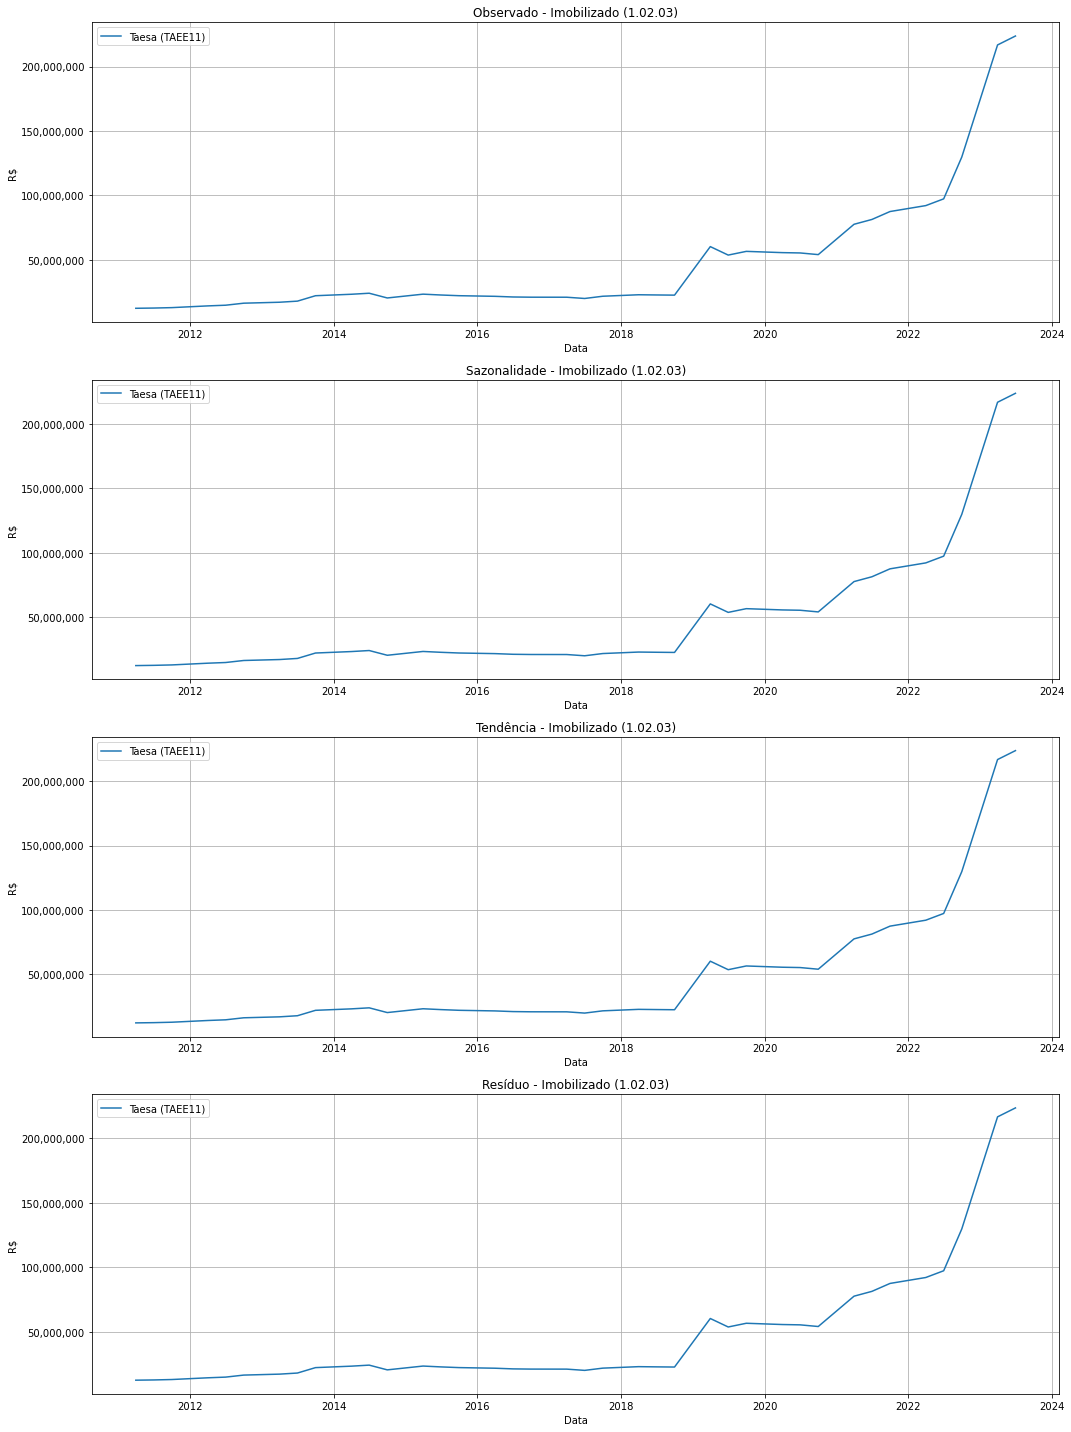


Checking if Imobilizado is stationary
ADF Statistic: 3.7724502564448223
ADF p-value: 1.0
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}




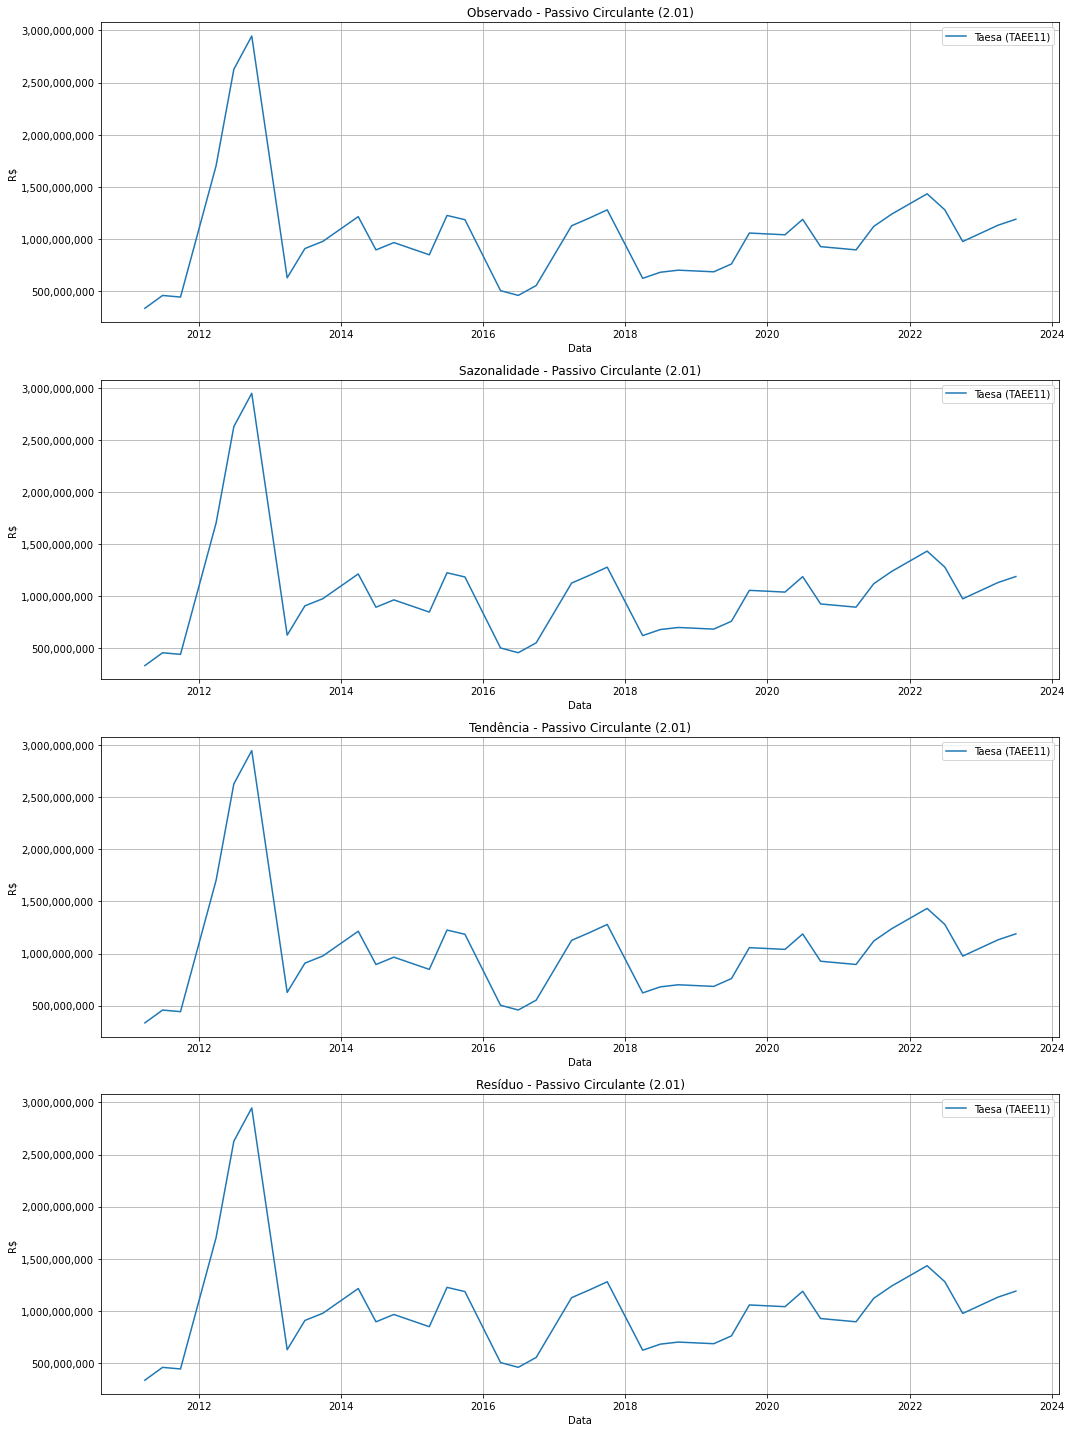


Checking if Passivo Circulante is stationary
ADF Statistic: -2.101012922202895
ADF p-value: 0.2441074955129125
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}




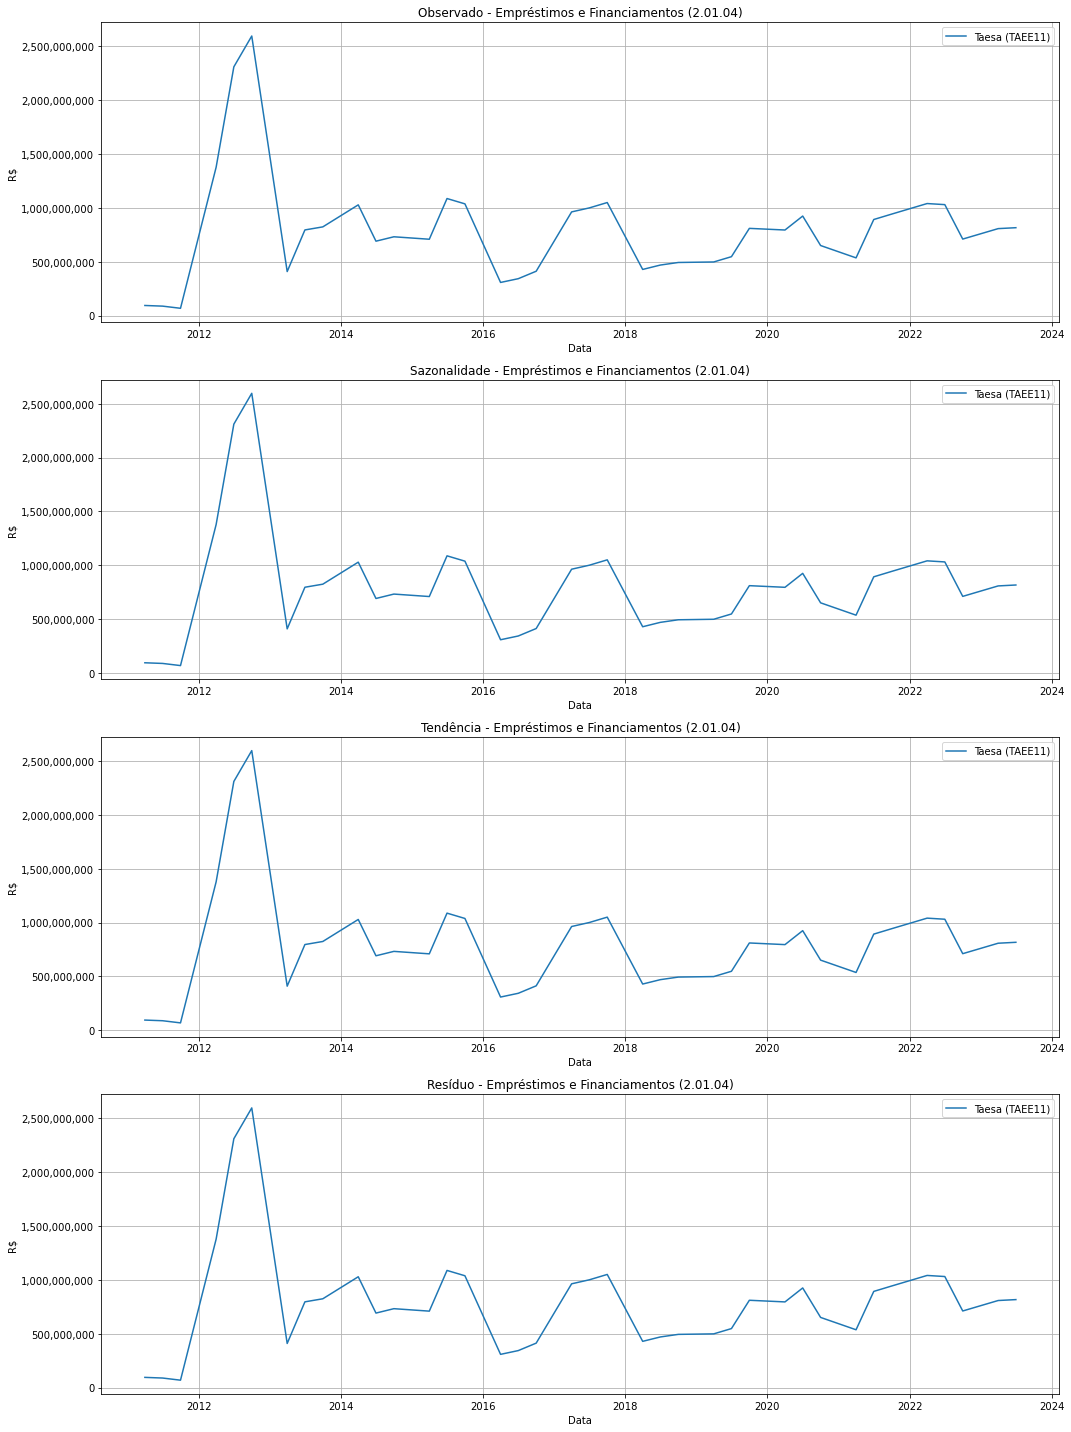


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -2.796039411044252
ADF p-value: 0.058841740922901696
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




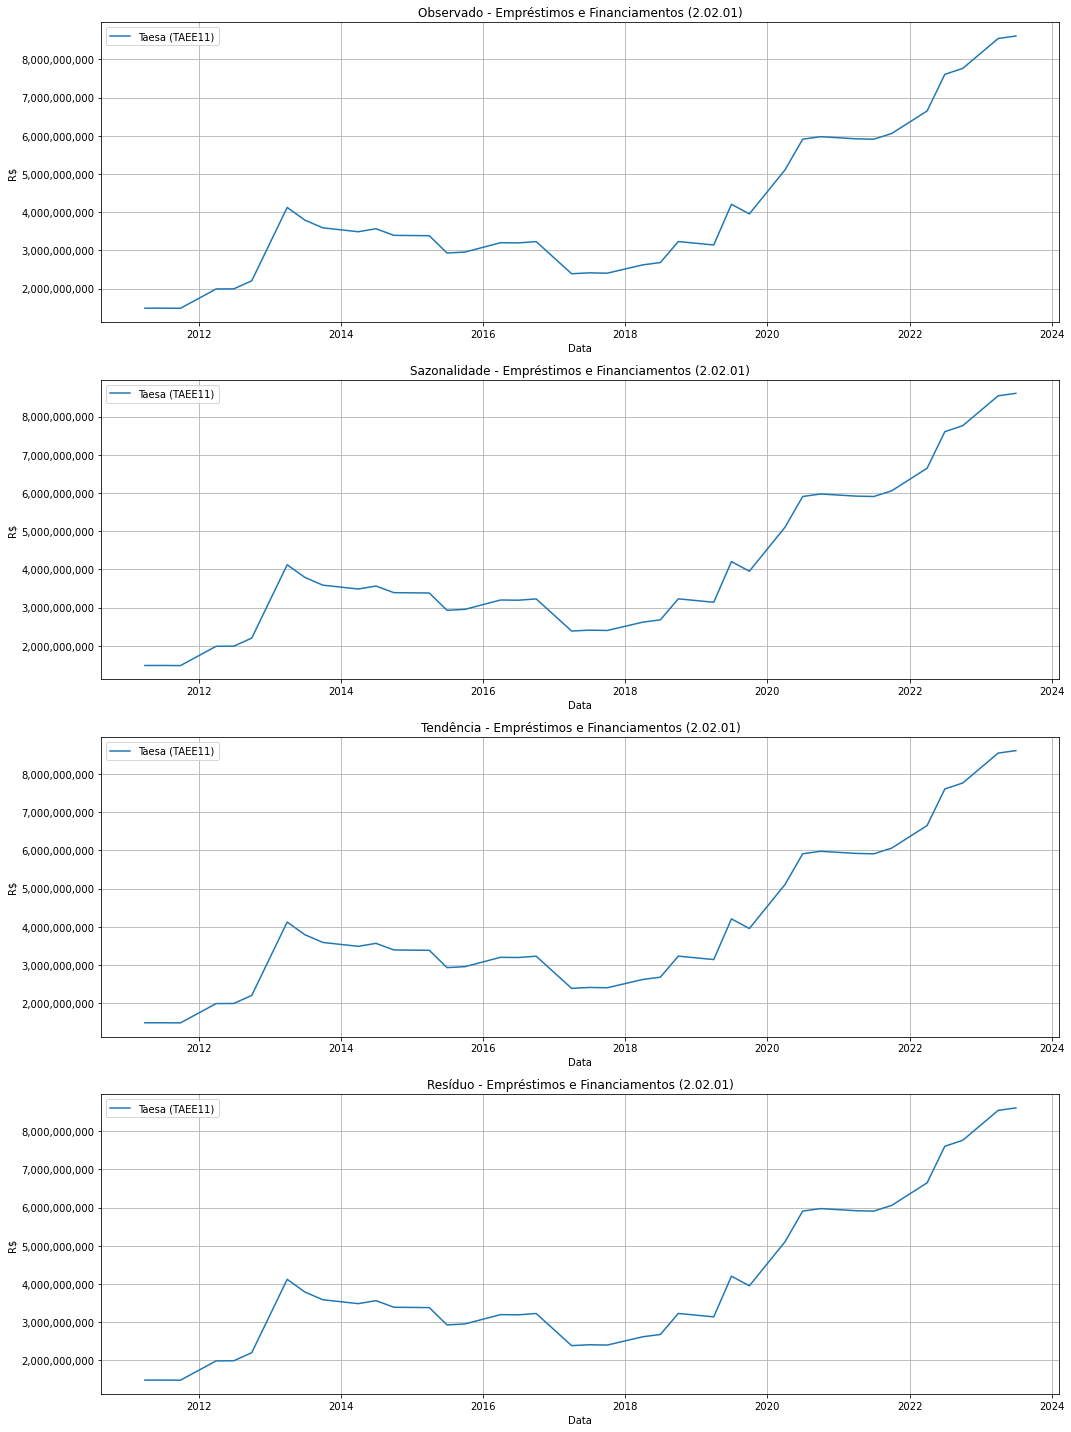


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: 0.51626276779643
ADF p-value: 0.9853590975005982
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




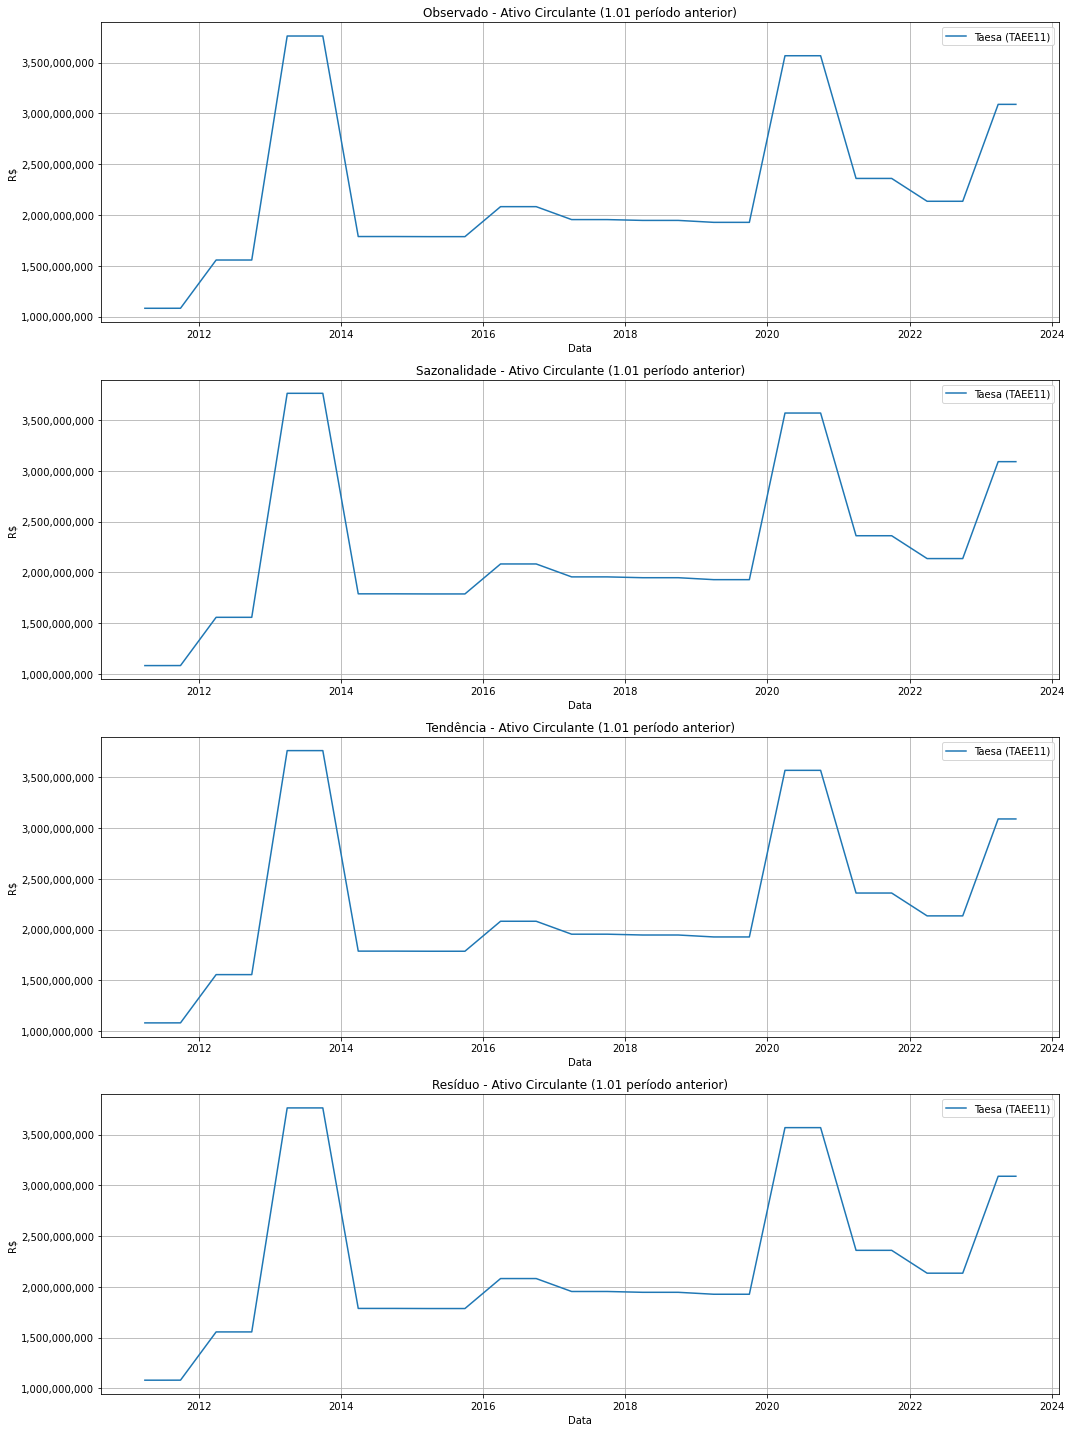


Checking if Ativo Circulante is stationary
ADF Statistic: -2.819591976020373
ADF p-value: 0.05552923246803539
Conclusion: The time series is NOT stationary

account
{'code': '1.01', 'name': 'Ativo Circulante', 'stationary': False, 'diff_count': 0}




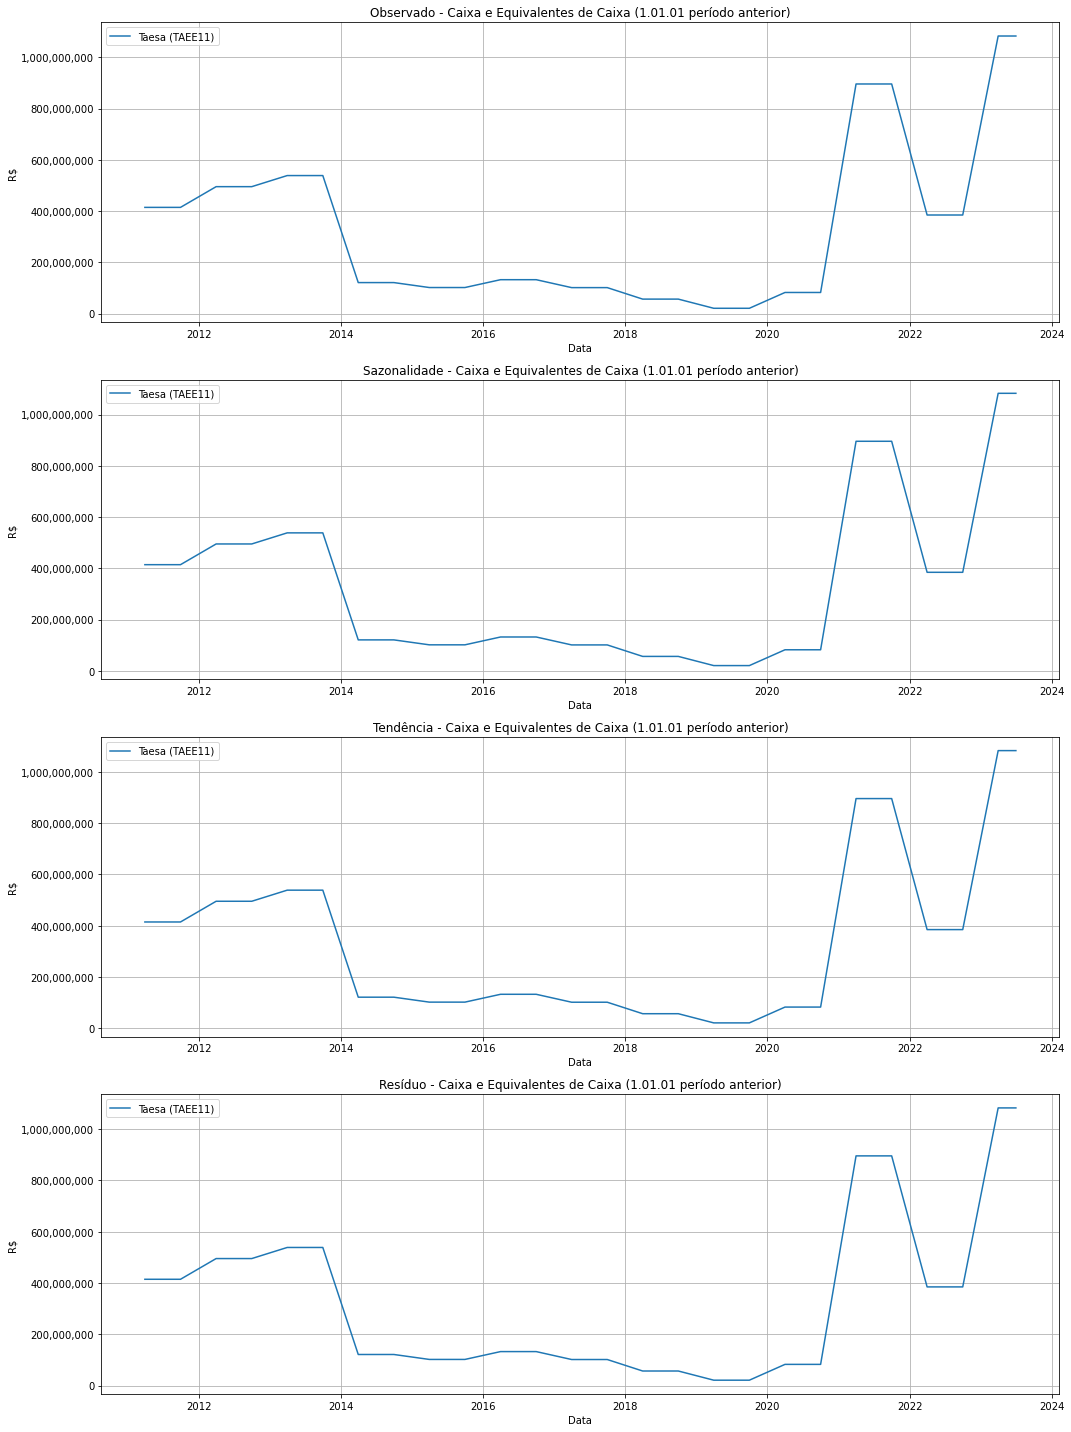


Checking if Caixa e Equivalentes de Caixa is stationary
ADF Statistic: -0.5430481586133618
ADF p-value: 0.883338687094362
Conclusion: The time series is NOT stationary

account
{'code': '1.01.01', 'name': 'Caixa e Equivalentes de Caixa', 'stationary': False, 'diff_count': 0}




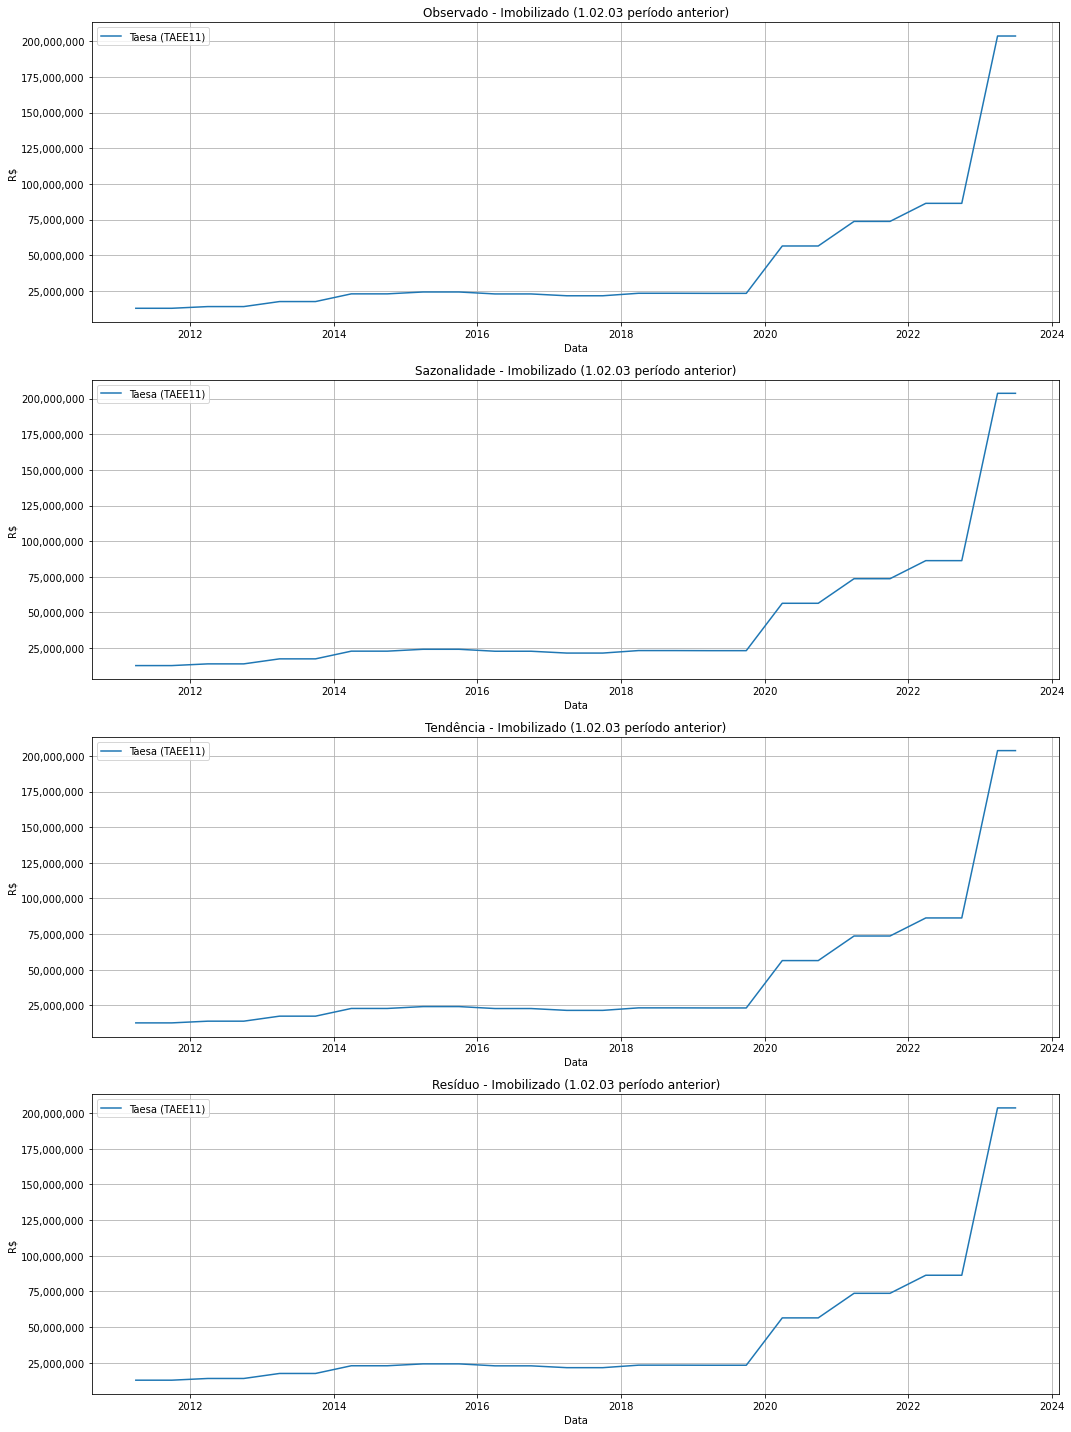


Checking if Imobilizado is stationary
ADF Statistic: 1.3489000643979918
ADF p-value: 0.9968691757790505
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}




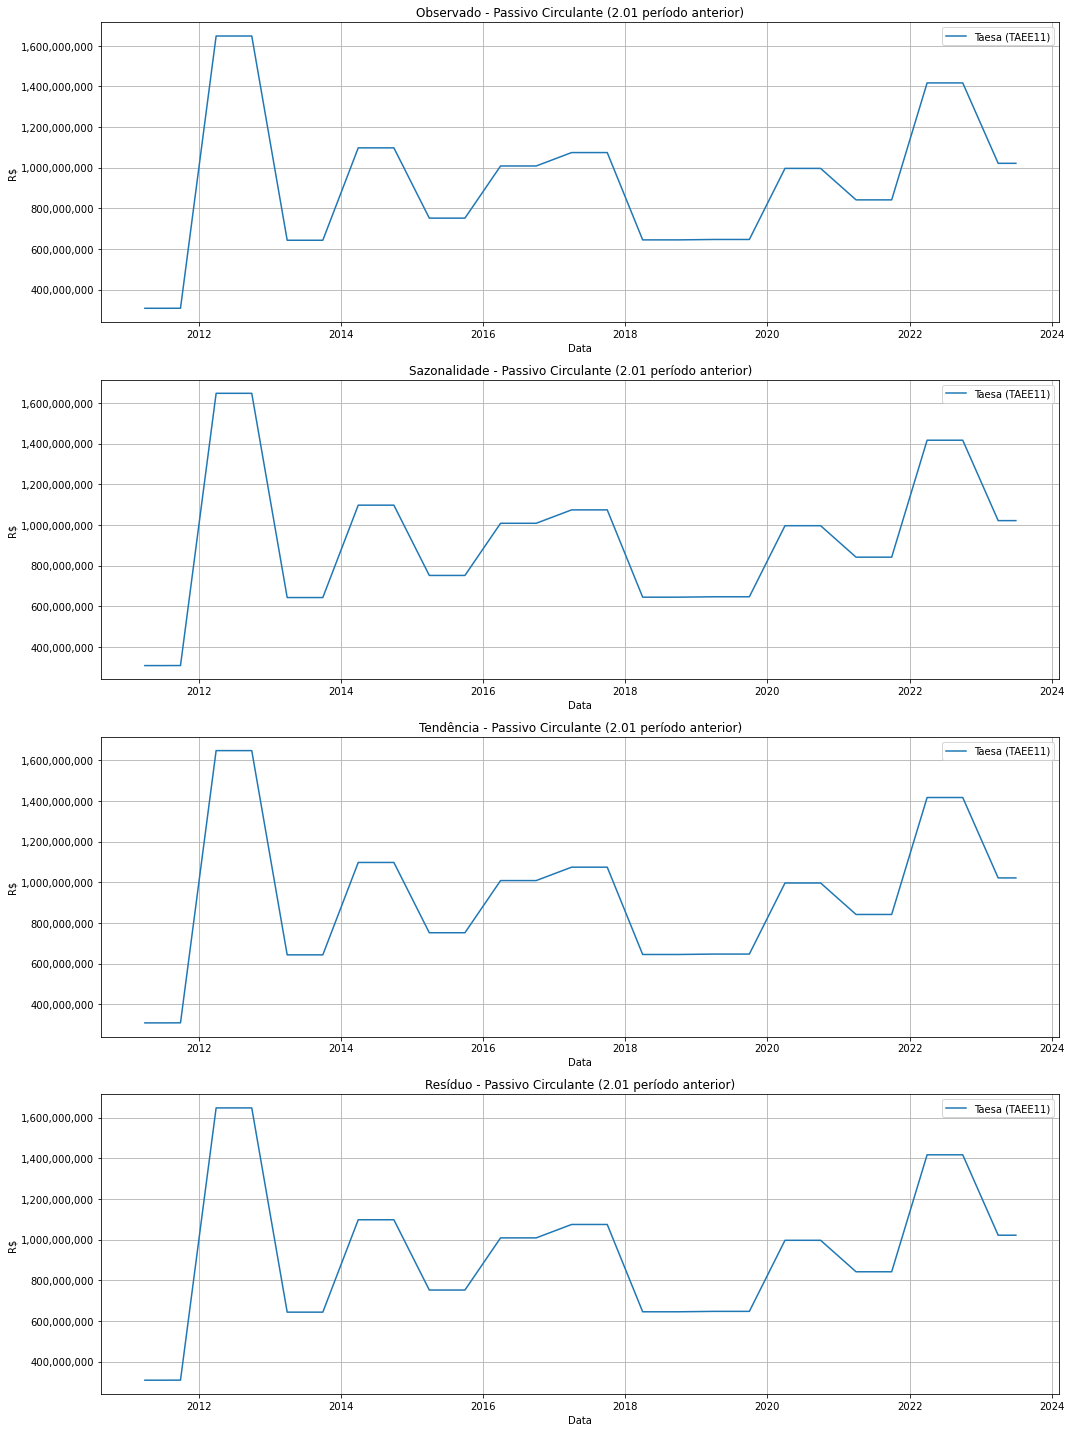


Checking if Passivo Circulante is stationary
ADF Statistic: -1.6159908001270424
ADF p-value: 0.47483178359663175
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}




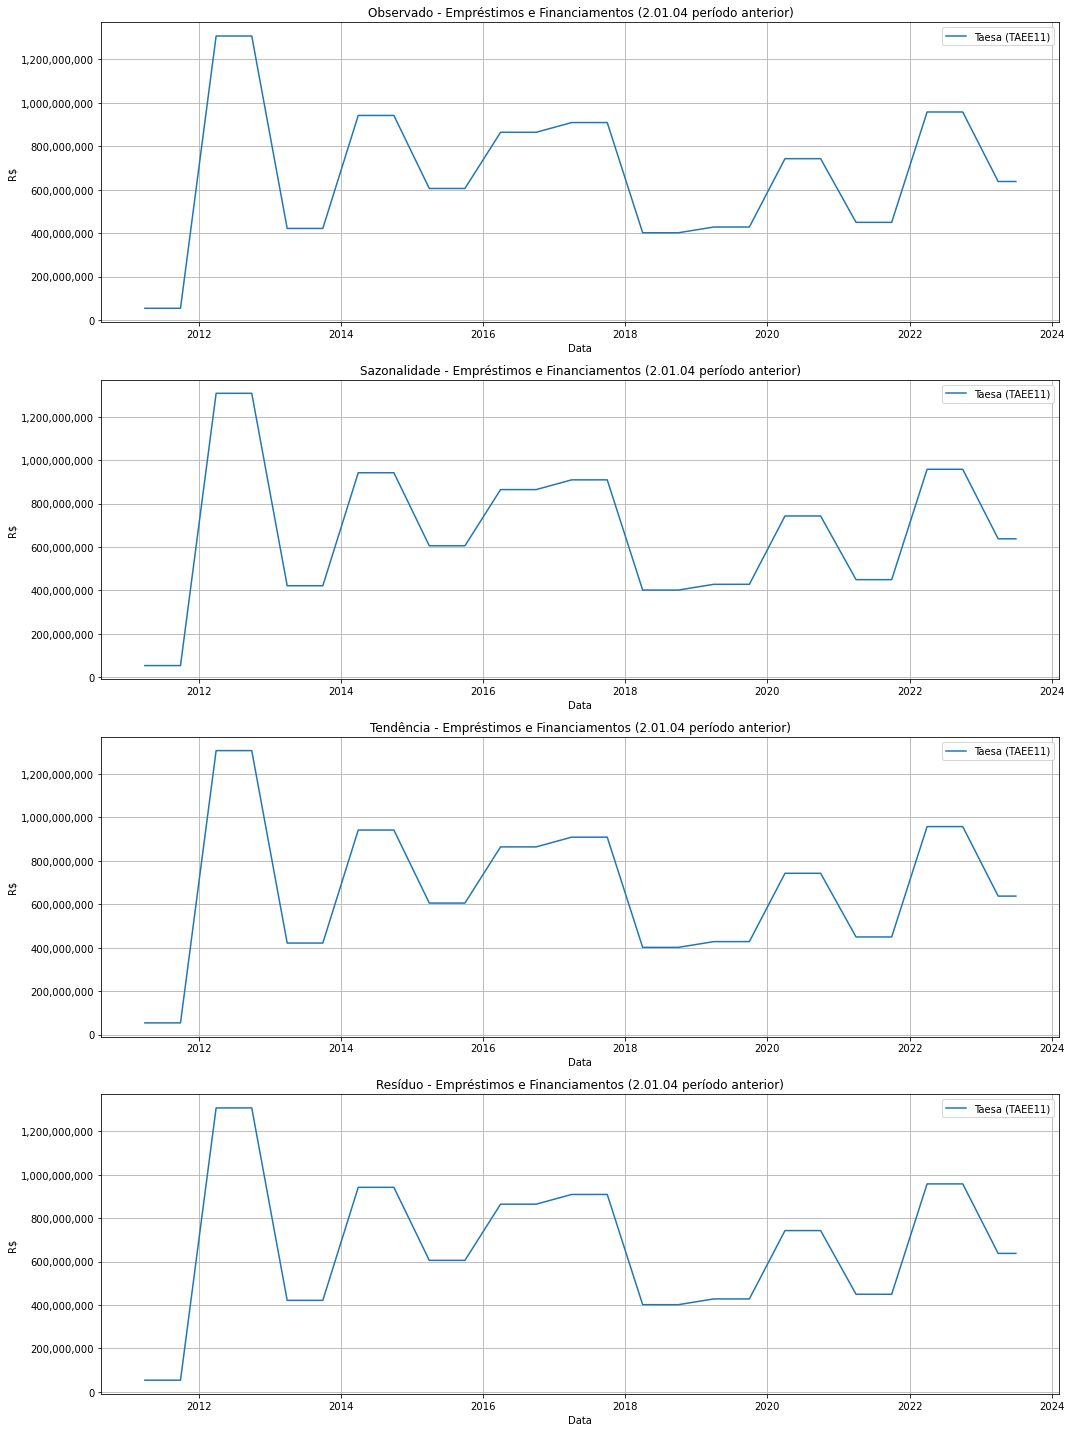


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -1.9767209836030832
ADF p-value: 0.2968724754411226
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




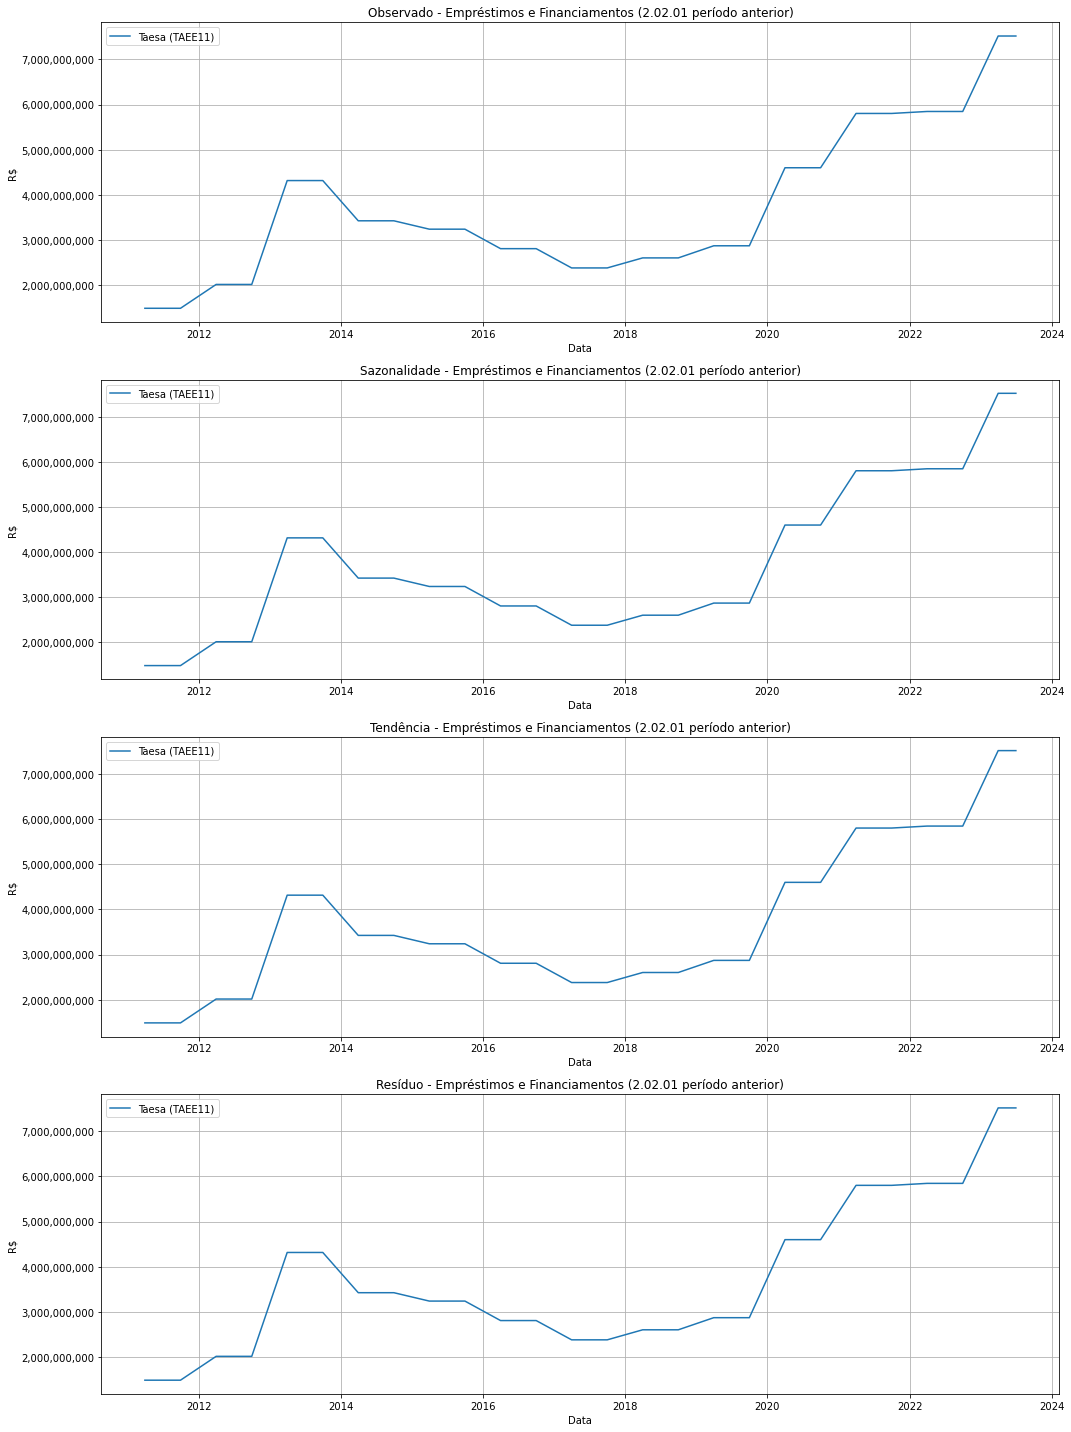


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -0.24805236484719123
ADF p-value: 0.932546234618134
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




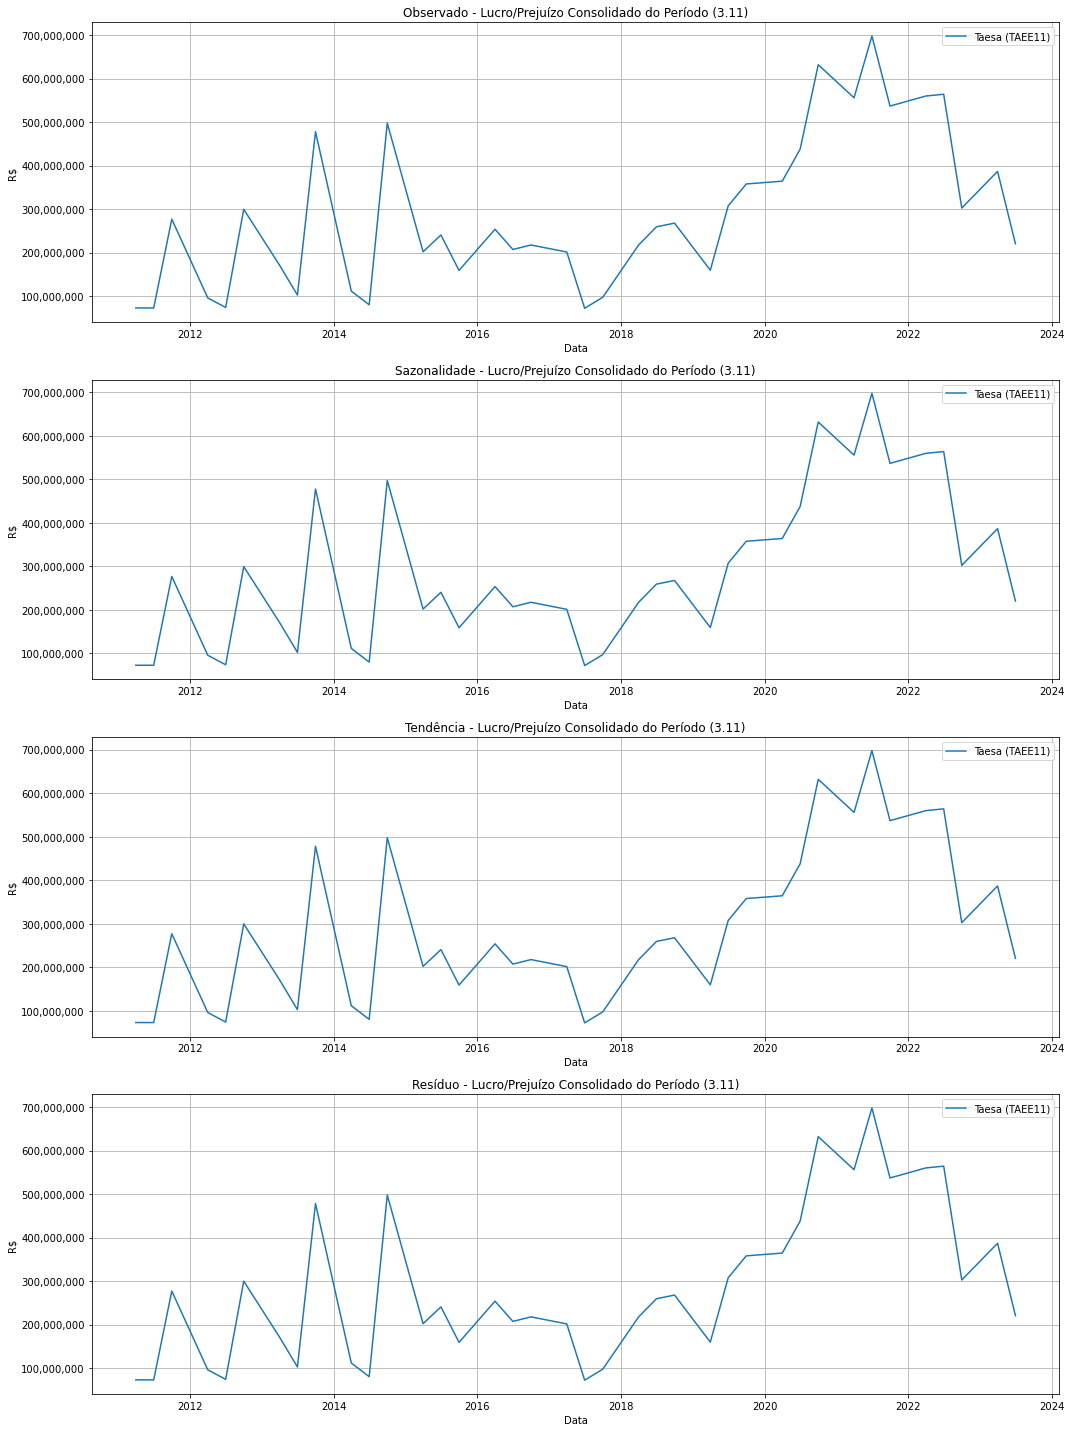


Checking if Lucro/Prejuízo Consolidado do Período is stationary
ADF Statistic: -2.9910162594886063
ADF p-value: 0.035741928590166214
Conclusion: The time series is stationary

account
{'code': '3.11', 'name': 'Lucro/Prejuízo Consolidado do Período', 'stationary': True, 'diff_count': 0}




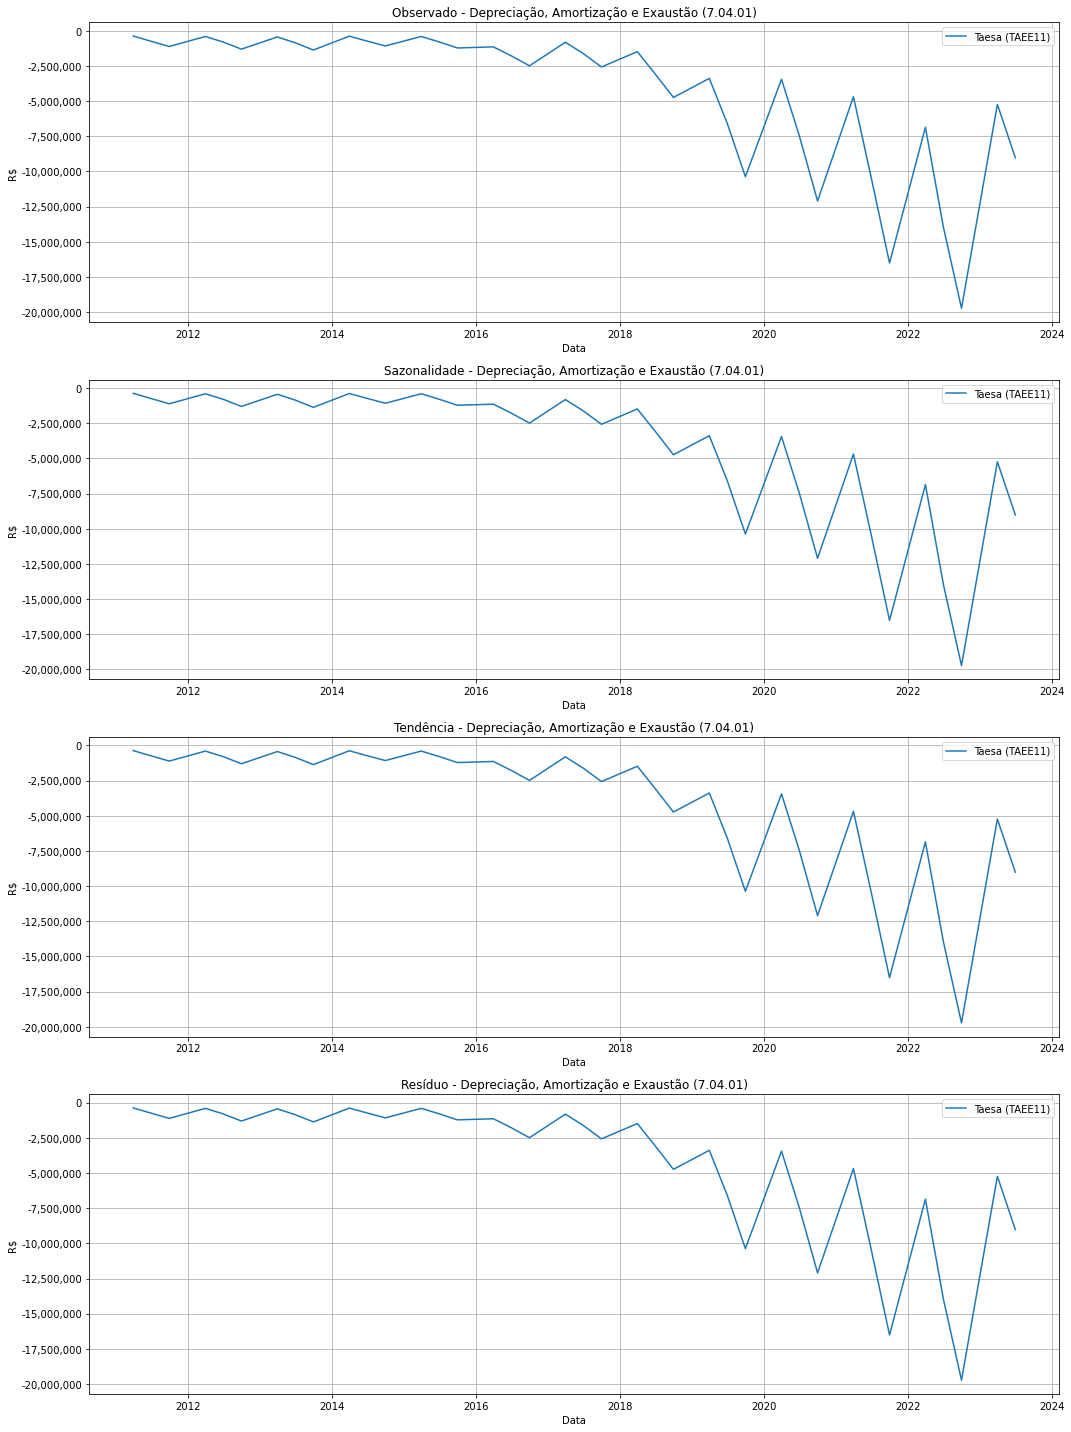


Checking if Depreciação, Amortização e Exaustão is stationary
ADF Statistic: -3.001015237093006
ADF p-value: 0.03479969861682131
Conclusion: The time series is stationary

account
{'code': '7.04.01', 'name': 'Depreciação, Amortização e Exaustão', 'stationary': True, 'diff_count': 0}




In [151]:
import pandas as pd
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# thousand separator
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
P_VALUE = 0.05

# reading data
df_pivot = readCsv('pivot', '.', 'DT_REFER', 'Q')


def print_graph(size, index, data, company, title, account, account_number):
    plt.subplot(size, 1, index)
    plt.plot(data, label=f"{company['name']} ({company['ticker']})")
    plt.title(f"{title} - {account['name']} ({account_number})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)


def check_stationarity(data, name):
    print(f'\nChecking if {name} is stationary')
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    is_stationary = adf_p_value <= P_VALUE
    if is_stationary:
        #print("Conclusão: A série é estacionária.")
        print("Conclusion: The time series is stationary")
    else:
        #print("Conclusão: A série NÃO é estacionária.")
        print("Conclusion: The time series is NOT stationary")
    return is_stationary


def decompose_and_print(df, accounts):
    for company_code in companies:
        company_data = df[df['CD_CVM'] == company_code]
        company = companies[company_code]

        for account_key in accounts:
            account = accounts[account_key]

            account_number = re.sub(r'VL_CONTA_PENULTIMO_(.*)', r'\1 período anterior', account_key)
            account_number = re.sub(r'VL_CONTA_', r'', account_number)

            # 4 = quarter division
            decomposition = seasonal_decompose(company_data[account_key], model='additive', period=4)

            plt.figure(figsize=(15, 20))

            print_graph(4, 1, decomposition.observed, company, 'Observado', account, account_number)
            print_graph(4, 2, decomposition.observed, company, 'Sazonalidade', account, account_number)
            print_graph(4, 3, decomposition.observed, company, 'Tendência', account, account_number)
            print_graph(4, 4, decomposition.observed, company, 'Resíduo', account, account_number)

            plt.tight_layout()
            plt.grid(True)
            plt.show()


            account['stationary'] = check_stationarity(company_data[account_key], account['name'])

            print('\naccount')
            print(account)
            print('\n')


decompose_and_print(df_pivot, accounts_to_calculate_fcfe)


#### 5.1.2 Making non-stationary series stationary

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker


def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE


def decompose_series(data, period=12):
    return sm.tsa.seasonal_decompose(data, period=period)


def plot_decomposition(series, title):
    plt.figure(figsize=(14, 7))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    decomposition = decompose_series(series)

    components = [('Trend', decomposition.trend), ('Seasonal', decomposition.seasonal), ('Residual', decomposition.resid)]
    for i, (label, component) in enumerate(components, 1):
        plt.subplot(3, 1, i)
        plt.plot(component)
        plt.title(f"{title} - {label}")
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_overlaid_decomposition(original_series, transformed_series, title):
    """Plot the overlaid original, trend, and residual decomposition of two time series."""
    orig_decomposition = decompose_series(original_series)
    trans_decomposition = decompose_series(transformed_series)

    plt.figure(figsize=(18, 6))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    components = [('Original Series', original_series, transformed_series),
                  ('Trend', orig_decomposition.trend, trans_decomposition.trend),
                  ('Residual', orig_decomposition.resid, trans_decomposition.resid)]

    for i, (label, orig_component, trans_component) in enumerate(components, 1):
        plt.subplot(1, 3, i)
        plt.plot(orig_component.index, orig_component, label=f'{label} Original', color='blue')
        plt.plot(trans_component.index, trans_component, label=f'{label} Transformada', color='red')
        plt.title(f"{title} - {label}")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def make_series_stationary(series, max_diff=5):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        if adfuller_test(stationary_series):
            return stationary_series
    return None


def main():
    for company_code, company_series in non_stationary_companies.items():
        company_info = companies[company_code]
        company_data = data[data['CD_CVM'] == company_code]['FCFE']

        print(f"\nTransformando série para a empresa {company_info['name']} ({company_info['ticker']})\n")

        # Plot original series
        plot_decomposition(company_data, title=f"Decomposicao da Serie Original: {company_info['name']}")

        # Making the series stationary
        stationary_series = make_series_stationary(company_data)

        print(f"\nValidando Pós Transformação para a empresa {company_info['name']} ({company_info['ticker']})\n")
        check_stationarity(stationary_series)

        if stationary_series is not None:
            # Plot transformed series
            plot_decomposition(stationary_series, title=f"Decomposicao depois da Transformacao: {company_info['name']}")

            stationary_series_dict[company_code] = stationary_series
            plot_overlaid_decomposition(company_data, stationary_series, company_info['name'])


if __name__ == "__main__":
    main()


print(stationary_series_dict)








import pandas as pd
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# thousand separator
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
P_VALUE = 0.05

# reading data
df_pivot = readCsv('pivot', '.', 'DT_REFER', 'Q')


def print_graph(size, index, data, company, title, account, account_number):
    plt.subplot(size, 1, index)
    plt.plot(data, label=f"{company['name']} ({company['ticker']})")
    plt.title(f"{title} - {account['name']} ({account_number})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)


def check_stationarity(data, name):
    print(f'\nChecking if {name} is stationary')
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    is_stationary = adf_p_value <= P_VALUE
    if is_stationary:
        #print("Conclusão: A série é estacionária.")
        print("Conclusion: The time series is stationary")
    else:
        #print("Conclusão: A série NÃO é estacionária.")
        print("Conclusion: The time series is NOT stationary")
    return is_stationary


def decompose_and_print(df, accounts):
    for company_code in companies:
        company_data = df[df['CD_CVM'] == company_code]
        company = companies[company_code]

        for account_key in accounts:
            account = accounts[account_key]

            account_number = re.sub(r'VL_CONTA_PENULTIMO_(.*)', r'\1 período anterior', account_key)
            account_number = re.sub(r'VL_CONTA_', r'', account_number)

            # 4 = quarter division
            decomposition = seasonal_decompose(company_data[account_key], model='additive', period=4)

            plt.figure(figsize=(15, 20))

            print_graph(4, 1, decomposition.observed, company, 'Observado', account, account_number)
            print_graph(4, 2, decomposition.observed, company, 'Sazonalidade', account, account_number)
            print_graph(4, 3, decomposition.observed, company, 'Tendência', account, account_number)
            print_graph(4, 4, decomposition.observed, company, 'Resíduo', account, account_number)

            plt.tight_layout()
            plt.grid(True)
            plt.show()


            account['stationary'] = check_stationarity(company_data[account_key], account['name'])

            print('\naccount')
            print(account)
            print('\n')


decompose_and_print(df_pivot, accounts_to_calculate_fcfe)


### 5.2 Modeling


#### 5.2.1 ARIMA

In [ ]:
# ARIMA
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

group_of_months = 4
frequency = 'D' 

df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')

for company_code in companies:
    company = companies[company_code]
    company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
    # Split data
    split_ratio = 0.9
    train_size = int(len(company_data) * split_ratio)
    train = company_data['FCFE'].iloc[:train_size]
    test = company_data['FCFE'].iloc[train_size:]

    model = pm.auto_arima(train,
                          seasonal=True, m=group_of_months,
                          d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                          trace=True, error_action='ignore', suppress_warnings=True)

    end_date = pd.to_datetime('2024-12-31')
    n_forecast_test = len(test)
    n_forecast_future = (end_date - train.index[-1]).days + 1
    n_forecast_total = n_forecast_test + n_forecast_future

    forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
    predicted = model.predict(n_periods=n_forecast_total)
    predicted_series = pd.Series(predicted, index=forecast_index)

    if predicted_series.isnull().any():
        print("Tentando um modelo mais simples...")
        model = pm.ARIMA(order=(1, 0, 1))
        model.fit(train)
        predicted = model.predict(n_periods=n_forecast_total)
        predicted_series = pd.Series(predicted, index=forecast_index)

    mape = mean_absolute_percentage_error(test, predicted[:n_forecast_test])
    accuracy = 100 - mape
    print(f"\nMAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%\n")

    plt.figure(figsize=(15, 5))
    plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
    plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
    plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
    plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    plt.grid(True)
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=124084.373, Time=51.75 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=149873.900, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=inf, Time=4.50 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=149872.201, Time=0.14 sec
 ARIMA(2,0,2)(0,1,1)[4] intercept   : AIC=inf, Time=23.04 sec
 ARIMA(2,0,2)(1,1,0)[4] intercept   : AIC=124924.021, Time=52.74 sec
 ARIMA(2,0,2)(2,1,1)[4] intercept   : AIC=inf, Time=50.18 sec
 ARIMA(2,0,2)(1,1,2)[4] intercept   : AIC=inf, Time=47.03 sec
 ARIMA(2,0,2)(0,1,0)[4] intercept   : AIC=inf, Time=29.57 sec
 ARIMA(2,0,2)(0,1,2)[4] intercept   : AIC=inf, Time=37.06 sec
 ARIMA(2,0,2)(2,1,0)[4] intercept   : AIC=inf, Time=46.87 sec
 ARIMA(2,0,2)(2,1,2)[4] intercept   : AIC=inf, Time=57.99 sec


KeyboardInterrupt: 

#### 5.2.2 ARIMA - with exogenous variables (multivariable)

In [ ]:
# ARIMA - with exogenous variables (multivariable)
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def remove_low_correlation_columns(df, threshold=0.5):
#     correlations = df.corrwith(df['FCFE'])
#     low_corr_columns = correlations[correlations.abs() < threshold].index.tolist()
#     return df.drop(columns=low_corr_columns)

group_of_months = 4
months = 3
frequency = 'D' 

# Read the data
df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

for company_code in companies:
    company = companies[company_code]
    company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
    # Remove columns with low correlation
    # company_data = remove_low_correlation_columns(company_data)
    
    # Split data
    split_ratio = 0.9
    train_size = int(len(company_data) * split_ratio)
    train = company_data.iloc[:train_size]
    test = company_data.iloc[train_size:]
    exog_train = train.drop(columns=['FCFE', 'CD_CVM'])

    assert not exog_train.isnull().any().any(), "Existem NaNs em exog_train"

    model = pm.auto_arima(train['FCFE'],
                          exogenous=exog_train,
                          seasonal=True, m=group_of_months,
                          d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                          trace=True, error_action='ignore', suppress_warnings=True)

    end_date = pd.to_datetime('2024-12-31')
    n_forecast_test = len(test)
    n_forecast_future = (end_date - train.index[-1]).days + 1
    n_forecast_total = n_forecast_test + n_forecast_future
    
    forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
    exog_forecast = pd.DataFrame([exog_train.iloc[-1]] * n_forecast_total, columns=exog_train.columns, index=forecast_index)

    predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
    predicted_series = pd.Series(predicted, index=forecast_index)

    if predicted_series.isnull().any():
        print("Tentando um modelo mais simples...")
        model = pm.ARIMA(order=(1, 0, 1))
        model.fit(train['FCFE'], exogenous=exog_train)
        predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
        predicted_series = pd.Series(predicted, index=forecast_index)

    mape = mean_absolute_percentage_error(test['FCFE'], predicted[:n_forecast_test])
    accuracy = 100 - mape
    print(f"\nMAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%\n")

    plt.figure(figsize=(15, 5))
    plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
    plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
    plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
    plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    plt.grid(True)
    plt.show()


#### 5.2.3 GLM

In [ ]:
# GLM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Read the data
df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

for company_code in companies:
    company = companies[company_code]
    company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
    # Train the model on all available data up to the current date for better predictions
    X = company_data.drop(columns=['FCFE', 'CD_CVM'])
    y = company_data['FCFE']
    
    features = stepwise_selection(X, y)

    X = sm.add_constant(company_data[features])
    model = sm.GLM(y, X).fit()

    # Predict on existing data
    predicted_existing = model.predict(X)

    # Create future data
    last_date = company_data.index[-1]
    future_dates = pd.date_range(last_date + DateOffset(days=1), '2024-12-31')
    future_data = pd.DataFrame(index=future_dates)
    future_data = future_data.join(df_pivot, how='left')  # Join to get the structure
    future_data['CD_CVM'] = company_code
    future_data[features] = np.nan  # No data for future, but you might have some other indicators/features
    
    X_future = sm.add_constant(future_data[features])
    predicted_future = model.predict(X_future)

    # Combine historical and predicted for plotting
    all_dates = company_data.index.append(future_dates)
    all_values = np.concatenate([company_data['FCFE'].values, predicted_future.values])

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(all_dates, all_values, label='FCFE Predito')
    plt.plot(company_data.index, company_data['FCFE'], label='FCFE Histórico', color='blue')
    plt.axvline(x=last_date, color='grey', linestyle='--', label='Início da Previsão')
    plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']})")
    plt.xlabel('Data')
    plt.ylabel('Fluxo de Caixa Livre')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    plt.grid(True)
    plt.show()


### 5.3 Free Cash Flow formula

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

#### 5.3.1 Calculate FCFE value

In [ ]:
####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df_pivot['LUCRO_LIQUIDO_PERIODO'] = df_pivot['VL_CONTA_3.11']


####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.02.03']
df_pivot['IMOBILIZADO_NO_PERIODO'] = df_pivot['VL_CONTA_1.02.03']
df_pivot['DELTA_IMOBILIZADO'] = df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df_pivot['IMOBILIZADO_NO_PERIODO']


####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df_pivot['VL_CONTA_7.04.01']


####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01']
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_1.01']
df_pivot['DELTA_ATIVO_CIRCULANTE'] = df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['ATIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01.01']
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df_pivot['VL_CONTA_1.01.01']
df_pivot['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']


####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01']
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_2.01']
df_pivot['DELTA_PASSIVO_CIRCULANTE'] = df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01.04']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.01.04']
df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.02.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.02.01']
df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df_pivot['FCFE'] = \
    df_pivot['LUCRO_LIQUIDO_PERIODO'] \
    - ( df_pivot['DELTA_IMOBILIZADO'] - df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df_pivot['DELTA_ATIVO_CIRCULANTE'] - df_pivot['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df_pivot['DELTA_PASSIVO_CIRCULANTE'] ) \
    + ( df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] + df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'])

df_pivot.head()


#### 5.3.2 Saving result

In [ ]:
saveToFile('fcfe', df_pivot)


#### 5.3.3 Loading result

In [ ]:
# def reorder(df, column, position):
#     cols = list(df.columns)
#     cols.remove(column)
#     cols.insert(position, column)
#     df = df[cols]
#     return df

# print_df = reorder(df_pivot, 'DT_REFER', 0)
# print_df = reorder(print_df, 'CD_CVM', 1)
# print_df = reorder(print_df, 'FCFE', 2)
# print_df = reorder(print_df, 'LUCRO_LIQUIDO_PERIODO', 3)
# print_df = reorder(print_df, 'DELTA_IMOBILIZADO', 4)
# print_df = reorder(print_df, 'DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA', 5)
# print_df = reorder(print_df, 'DELTA_ATIVO_CIRCULANTE', 6)
# print_df = reorder(print_df, 'DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA', 7)
# print_df = reorder(print_df, 'DELTA_PASSIVO_CIRCULANTE', 8)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES', 9)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES', 10)

# print_df.head()

# df_pivot = df_pivot.set_index('DT_REFER')


#df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')
df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

print("\n")
print(df_pivot.info())
print("\n")
print(df_pivot.head(100))


## 5 Exploratory Data Analysis (EDA)

### 5.1 Loading the data already strutured and cleaned

In [ ]:
import pandas as pd

data = pd.read_csv('df_fcfe.csv', sep=';')

data['DT_REFER'] = pd.to_datetime(data['DT_REFER'], format='%Y-%m-%d')
data = data.set_index('DT_REFER')


### 5.6 Non-stationarity transformations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.ticker as ticker


def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE


def decompose_series(data, period=12):
    return sm.tsa.seasonal_decompose(data, period=period)


def plot_decomposition(series, title):
    plt.figure(figsize=(14, 7))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    decomposition = decompose_series(series)

    components = [('Trend', decomposition.trend), ('Seasonal', decomposition.seasonal), ('Residual', decomposition.resid)]
    for i, (label, component) in enumerate(components, 1):
        plt.subplot(3, 1, i)
        plt.plot(component)
        plt.title(f"{title} - {label}")
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_overlaid_decomposition(original_series, transformed_series, title):
    """Plot the overlaid original, trend, and residual decomposition of two time series."""
    orig_decomposition = decompose_series(original_series)
    trans_decomposition = decompose_series(transformed_series)

    plt.figure(figsize=(18, 6))
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

    components = [('Original Series', original_series, transformed_series),
                  ('Trend', orig_decomposition.trend, trans_decomposition.trend),
                  ('Residual', orig_decomposition.resid, trans_decomposition.resid)]

    for i, (label, orig_component, trans_component) in enumerate(components, 1):
        plt.subplot(1, 3, i)
        plt.plot(orig_component.index, orig_component, label=f'{label} Original', color='blue')
        plt.plot(trans_component.index, trans_component, label=f'{label} Transformada', color='red')
        plt.title(f"{title} - {label}")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.gca().yaxis.set_major_formatter(formatter)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def make_series_stationary(series, max_diff=2):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        if adfuller_test(stationary_series):
            return stationary_series
    return None


def main():
    for company_code, company_series in non_stationary_companies.items():
        company_info = companies[company_code]
        company_data = data[data['CD_CVM'] == company_code]['FCFE']

        print(f"\nTransformando série para a empresa {company_info['name']} ({company_info['ticker']})\n")

        # Plot original series
        plot_decomposition(company_data, title=f"Decomposicao da Serie Original: {company_info['name']}")

        # Making the series stationary
        stationary_series = make_series_stationary(company_data)

        print(f"\nValidando Pós Transformação para a empresa {company_info['name']} ({company_info['ticker']})\n")
        check_stationarity(stationary_series)

        if stationary_series is not None:
            # Plot transformed series
            plot_decomposition(stationary_series, title=f"Decomposicao depois da Transformacao: {company_info['name']}")

            stationary_series_dict[company_code] = stationary_series
            plot_overlaid_decomposition(company_data, stationary_series, company_info['name'])


if __name__ == "__main__":
    main()


print(stationary_series_dict)

### 5.7 Predictions

#### 5.7.1 Prediction using ARIMA

**ARIMA (Autoregressive Integrated Moving Average)**

It is a widely-used approach for time series forecasting. The model relies on three main components:

- **Autoregression (AR):** Refers to the relationship between an observation and a number of lagged observations.
- **Integrated (I):** Refers to the use of differencing to make the time series stationary.
- **Moving Average (MA):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Source:**
- Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

#### 5.7.2 Prediction using SARIMA

**SARIMA (Seasonal Autoregressive Integrated Moving Average)**

SARIMA adds an additional seasonal component to the ARIMA model, making it suitable for time series with clear seasonal patterns. The components of SARIMA are:

- **Seasonal Autoregression (SAR):** Refers to the relationship between an observation and a number of seasonally lagged observations.
- **Seasonal Integrated (SI):** Uses seasonal differencing to make the series stationary.
- **Seasonal Moving Average (SMA):** Uses the dependency between an observation and a residual error from a moving average model applied to seasonally lagged observations.

**Source:**
- Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: principles and practice*. OTexts.


#### 5.7.3 Prediction using XGBoost

**XGBoost (Extreme Gradient Boosting)**

XGBoost, short for "Extreme Gradient Boosting", is a decision-tree-based ensemble Machine Learning algorithm. It uses a gradient boosting framework. XGBoost is especially known for its speed and performance. For time series forecasting, it works best when combined with time-based features and lagged values of the series to be predicted.

- **Tree-based Modeling:** At its core, XGBoost constructs decision trees like other boosting algorithms, such as Gradient Boosting Machines (GBM).
- **Regularization:** XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting.
- **Parallel Processing:** It's known for its performance; it's parallel and distributed computing makes it incredibly fast.

**Source:**
- Chen, T., & Guestrin, C. (2016, August). *Xgboost: A scalable tree boosting system*. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 785-794).

#### 5.7.4 Prediction using LSTM

**LSTM (Long Short-Term Memory)**

LSTM is a special kind of Recurrent Neural Network (RNN) architecture optimized for sequences and time series data. Unlike traditional RNNs which struggle to learn and retain long-term dependencies due to issues like vanishing gradient, LSTMs are explicitly designed to avoid long-term dependency issues. The key features of LSTM are:

- **Memory Cell:** At its core, LSTM has a cell state, often referred to as the "memory cell", which can maintain its state over time, acting somewhat like a conveyor belt. It allows information to be passed down unchanged if needed.

- **Gates:** LSTMs have three gates to control the cell state and output:
  1. **Forget Gate:** Decides what information should be discarded or kept.
  2. **Input Gate:** Updates the cell state with new information.
  3. **Output Gate:** Determines the output based on the cell state and the input.

By virtue of these gates and the memory cell, LSTMs can model and predict patterns in time series and sequences over long periods effectively, making them popular for many sequence prediction problems.

**Sources:**
- Hochreiter, S., & Schmidhuber, J. (1997). *Long short-term memory*. Neural computation, 9(8), 1735-1780.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. [Online version available](http://www.deeplearningbook.org/)


##### 5.7.4.1 Data

In [ ]:
print(df.info())
print(df.head())

print(stationary_series_dict)

##### 5.7.4.2 Algorithms

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian


def generate_lags_multivariate(df, n_lags, target_column='FCFE'):
    """
    Generate lag features for multivariate time series data.
    """
    lag_data = []
    for i in range(n_lags, 0, -1):
        df_shifted = df.shift(i)
        df_shifted.columns = [f"{col}_lag{i}" for col in df.columns]
        lag_data.append(df_shifted)
    
    df_lagged = pd.concat(lag_data, axis=1)
    df_lagged = df_lagged.dropna()
    
    X = df_lagged.drop(columns=[f"{target_column}_lag{i}" for i in range(1, n_lags+1)])
    y = df_lagged[f"{target_column}_lag1"]
    
    return X.values, y.values


def arima_forecast(train_series, steps):
    print('\n------------------------------------------------------------------')
    print(f'[ arima_forecast ]')
    model = ARIMA(train_series, order=(1,1,1))
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=steps)
    return predictions

def sarima_forecast(train_series, steps):
    print('\n------------------------------------------------------------------')
    print(f'[ sarima_forecast ]')
    model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,4))
    fit_model = model.fit()
    predictions = fit_model.forecast(steps=steps)
    return predictions

def xgboost_forecast(train, steps):
    print('\n------------------------------------------------------------------')
    print(f'[ xgboost_forecast ]')
    X, y = generate_lags_multivariate(train, n_lags)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    forecasts = []
    recent_data = list(train[-n_lags:])
    for _ in range(steps):
        X_new = np.array([recent_data[-n_lags:]])
        forecast = model.predict(X_new)
        forecasts.append(forecast[0])
        recent_data.append(forecast[0])

    return np.array(forecasts)

def glm_forecast(train, steps):
    print('\n------------------------------------------------------------------')
    print(f'[ glm_forecast ]')
    X, y = generate_lags_multivariate(train, n_lags)
    
    glm = GLM(y, X, family=Gaussian())
    model = glm.fit()

    forecasts = []
    recent_data = list(train[-n_lags:])
    for _ in range(steps):
        X_new = np.array([recent_data[-n_lags:]])
        forecast = model.predict(X_new)
        forecasts.append(forecast[0])
        recent_data.append(forecast[0])

    return np.array(forecasts)


##### 5.7.4.3 Error Functions

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

# Função para calcular o MAPE
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

##### 5.7.4.4 Plotting Functions

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_ensemble_forecasts(train_series, test_series, arima_preds, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy):
    plt.figure(figsize=(18, 6))

    # Limitando os dados de treinamento para os últimos 3 anos
    three_years_ago = pd.Timestamp(train_series.index[-1] - pd.DateOffset(years=3))
    limited_train_series = train_series[three_years_ago:]

    plt.plot(limited_train_series.index, limited_train_series.values, label='Dados de Treinamento (Últimos 3 anos)', color='grey')

    # Criando o índice para as previsões
    forecast_start = train_series.index[-1] + pd.DateOffset(days=1)
    forecast_end = forecast_start + pd.DateOffset(days=len(arima_preds)-1)
    forecast_index = pd.date_range(forecast_start, forecast_end, freq='D')

    # Plotando o brilho para a linha do modelo vencedor
    glow_width = 4
    lw_arima, lw_sarima, lw_xgboost, lw_glm, lw_ensemble = 1, 1, 1, 1, 1
    if best_model == "ARIMA":
        lw_arima = 3
        plt.plot(forecast_index, arima_preds, color='red', linestyle='--', linewidth=glow_width, alpha=0.3)
    elif best_model == "SARIMA":
        lw_sarima = 3
        plt.plot(forecast_index, preds_sarima, color='green', linestyle='--', linewidth=glow_width, alpha=0.3)
    elif best_model == "XGBoost":
        lw_xgboost = 3
        plt.plot(forecast_index, preds_xgboost, color='cyan', linestyle='--', linewidth=glow_width, alpha=0.3)
    elif best_model == "GLM":
        lw_glm = 3
        plt.plot(forecast_index, preds_glm, color='orange', linestyle='--', linewidth=glow_width, alpha=0.3)
    else:
        lw_ensemble = 3
        plt.plot(forecast_index, preds_ensemble, color='black', linestyle='-', linewidth=glow_width, alpha=0.3)

    # Plotando as linhas regulares
    plt.plot(forecast_index, arima_preds, label='Previsões ARIMA', color='red', linestyle='--', linewidth=lw_arima)
    plt.plot(forecast_index, preds_sarima, label='Previsões SARIMA', color='green', linestyle='--', linewidth=lw_sarima)
    plt.plot(forecast_index, preds_xgboost, label='Previsões XGBoost', color='cyan', linestyle='--', linewidth=lw_xgboost)
    plt.plot(forecast_index, preds_glm, label='Previsões GLM', color='orange', linestyle='--', linewidth=lw_glm)
    plt.plot(forecast_index, preds_ensemble, label='Previsões Ensembled', color='black', linestyle='-', linewidth=lw_ensemble)
    plt.plot(test_series.index, test_series.values, label='Dados Reais', color='blue')

    plt.ylabel('Fluxo de Caixa Livre para os Acionistas (FCLA) em Reais')

    plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.title(f"Comparação para {company_name}: Dados de Treinamento, Dados Reais vs. Previsões (Melhor modelo: {best_model}) (Acurácia: {accuracy:.2f}%)")
    plt.grid(True)
    plt.show()

##### 5.7.4.5 Calling Algorithms

In [ ]:
import pandas as pd

for company_code, series in stationary_series_dict.items():
    print(f'\ncompany_code: {company_code}')
    company_name = companies[company_code]['name']

    # Ajuste de frequência e interpolação para os modelos ARIMA e SARIMA
    series_stationary = series.asfreq('D').interpolate(method='linear')
    series_stationary = series_stationary.asfreq('D')

    # Para XGBoost e GLM, você vai usar a série original, que está em 'df'
    # series_original = df[df['CD_CVM'] == company_code].asfreq('D').interpolate(method='linear')
    # series_original = series_original.asfreq('D')
    series_original = df[df['CD_CVM'] == company_code]

    # Aqui está a mudança: Definindo o ponto de divisão para treinamento até o final de 2022 (2022-12-31)
    split_date = pd.to_datetime(str((year_interval_end-1)) + "-12-31")


    # Criando séries de treinamento e teste para ARIMA e SARIMA (usando a série estacionária)
    train_series_stationary = series_stationary.loc[:split_date]
    test_series_stationary = series_stationary.loc[(split_date + pd.DateOffset(days=1)):]

    # Criando séries de treinamento e teste para XGBoost e GLM (usando a série original)
    train_series_original = series_original.loc[:split_date]
    test_series_original = series_original.loc[(split_date + pd.DateOffset(days=1)):]


    # Forecasts individuais
    # (2024-12-31) - (2022-12-31) = 2 years = 2 * 365 = 730
    forecast_steps = (pd.to_datetime(str(year_interval_end+1) + "-12-31") - split_date).days
    print(f'\nforecast_steps: {forecast_steps}\n')


    # Usando a série estacionária para ARIMA e SARIMA
    preds_arima = arima_forecast(train_series_stationary.values, forecast_steps)
    preds_sarima = sarima_forecast(train_series_stationary.values, forecast_steps)

    # Usando a série original para XGBoost e GLM
    #preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
    #preds_glm = glm_forecast(train_series_original.values, forecast_steps)
    preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
    preds_glm = glm_forecast(train_series_original.values, forecast_steps)


   # Ensemble forecast
    preds_ensemble = (preds_arima + preds_sarima + preds_xgboost + preds_glm) / 4


    # Calculando erros
    rmse_arima = calculate_rmse(test_series_stationary.values, preds_arima[:len(test_series_stationary)])
    print(f'ARIMA error: {rmse_arima}')
    rmse_sarima = calculate_rmse(test_series_stationary.values, preds_sarima[:len(test_series_stationary)])
    print(f'SARIMA error: {rmse_sarima}')
    rmse_xgboost = calculate_rmse(test_series_original.values, preds_xgboost[:len(test_series_original)])
    print(f'XGBoost error: {rmse_xgboost}')
    rmse_glm = calculate_rmse(test_series_original.values, preds_glm[:len(test_series_original)])
    print(f'GLM error: {rmse_glm}')

    # Para o ensemble, vamos assumir que test_series_stationary é do mesmo tamanho que test_series_original
    rmse_ensemble = calculate_rmse(test_series_original.values, preds_ensemble[:len(test_series_original)])
    print(f'Ensemble error: {rmse_ensemble}')

    best_rmse = min(rmse_arima, rmse_sarima, rmse_xgboost, rmse_glm, rmse_ensemble)


    # Accuracy
    mape_arima = calculate_mape(test_series_stationary, preds_arima[:len(test_series_stationary)])
    mape_sarima = calculate_mape(test_series_stationary, preds_sarima[:len(test_series_stationary)])
    mape_xgboost = calculate_mape(test_series_original, preds_xgboost[:len(test_series_original)])
    mape_glm = calculate_mape(test_series_original, preds_glm[:len(test_series_original)])
    mape_ensemble = calculate_mape(test_series_original, preds_ensemble[:len(test_series_original)])

    accuracy_arima = 100 - mape_arima
    accuracy_sarima = 100 - mape_sarima
    accuracy_xgboost = 100 - mape_xgboost
    accuracy_glm = 100 - mape_glm
    accuracy_ensemble = 100 - mape_ensemble

    if best_rmse == rmse_arima:
        best_model = "ARIMA"
        accuracy = accuracy_arima
    elif best_rmse == rmse_sarima:
        best_model = "SARIMA"
        accuracy = accuracy_sarima
    elif best_rmse == rmse_xgboost:
        best_model = "XGBoost"
        accuracy = accuracy_xgboost
    elif best_rmse == rmse_glm:
        best_model = "GLM"
        accuracy = accuracy_glm
    else:
        best_model = "Ensemble"
        accuracy = accuracy_ensemble

    print(f"\nPara a empresa {company_name}:")
    print(f"ARIMA - RMSE: {rmse_arima:.2f}  MAPE: {mape_arima:.2f}  100-MAPE: {accuracy_arima:.2f}%")
    print(f"SARIMA - RMSE: {rmse_sarima:.2f}  MAPE: {mape_sarima:.2f}  100-MAPE: {accuracy_sarima:.2f}%")
    print(f"XGBoost - RMSE: {rmse_xgboost:.2f}  MAPE: {mape_xgboost:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
    print(f"GLM - RMSE: {rmse_glm:.2f}  MAPE: {mape_glm:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
    print(f"Ensembled - RMSE: {rmse_ensemble:.2f}  MAPE: {mape_ensemble:.2f}  100-MAPE: {accuracy_ensemble:.2f}%")
    print("\n")
    print(f"Melhor modelo: {best_model}")
    print(f"Acurácia do modelo vencedor: {accuracy:.2f}%\n")

    plot_ensemble_forecasts(train_series_original, test_series_original, preds_arima, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy)